In [1]:
%reload_ext autoreload
%autoreload 2

#set cuda visible to only #3 GPU
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


#### Test gen_z generation

In [2]:
import torch
import pickle


In [3]:
with open("testa/q.pkl", 'rb') as f:
    q = pickle.load(f)

In [4]:
q

tensor([[ 1.0286,  0.4569, -1.9363,  ..., -0.7895, -0.9793, -0.4020],
        [ 0.5721,  0.2072,  0.4737,  ..., -0.3213,  0.6505,  0.5591]],
       device='cuda:0')

In [5]:
import dnnlib
import torch
import legacy
from training.networks_stylegan3 import Generator
network_pkl = "pretrained/stylegan3-r-ffhq-1024x1024.pkl"
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as f:
    G_t = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

In [6]:
G_1k = Generator(
    c_dim=0,
    img_resolution=1024,
    img_channels=3,
    z_dim=512,
    w_dim=512,
    mapping_kwargs=dnnlib.EasyDict(num_layers=2),
    magnitude_ema_beta=0.5 ** (64 / (20 * 1e3)),
    conv_kernel = 1,
    channel_base = 32768 * 2,
    channel_max = 1024,
    use_radial_filters = True,
    actual_resolution = 1024,
).to(device)
G_1k.load_state_dict(G_t.state_dict())

<All keys matched successfully>

In [7]:
int(False)

0

In [8]:
G_1k.mapping.fc0.weight.shape

torch.Size([512, 512])

In [13]:
w = G_1k.mapping.__class__(**G_1k.mapping.init_kwargs, bcond=True).eval()

In [11]:
G_1k.load_state_dict(G_t.state_dict())

<All keys matched successfully>

In [13]:
G_1k.mapping.state_dict().keys()

odict_keys(['w_avg', 'fc0.weight', 'fc0.bias', 'fc1.weight', 'fc1.bias'])

In [17]:
w.fc0.bias.shape

torch.Size([512])

In [19]:
for idx, (key, value) in enumerate(G_1k.mapping.state_dict().items()):
    # also print w state dict with same idx
    print(key, f"Destination", w.state_dict()[key].shape, "Source", value.shape)

w_avg Destination: torch.Size([512]) Source torch.Size([512])
fc0.weight Destination: torch.Size([512, 513]) Source torch.Size([512, 512])
fc0.bias Destination: torch.Size([512]) Source torch.Size([512])
fc1.weight Destination: torch.Size([512, 512]) Source torch.Size([512, 512])
fc1.bias Destination: torch.Size([512]) Source torch.Size([512])


In [18]:
from torch_utils import misc
with torch.no_grad():
    misc.copy_params_and_buffers(G_1k.mapping, w)
#w.load_state_dict(G_1k.mapping.state_dict(), strict=False)

NotImplementedError: mapping.fc0.weight is not one less than src_tensor, not implemented

In [32]:
G_1k.mapping.init_kwargs

{'z_dim': 512, 'c_dim': 0, 'w_dim': 512, 'num_ws': 16, 'num_layers': 2}

In [21]:
# check if the sizes of the buffers are same
what = G_t.state_dict().items()
#what = G_t.named_parameters()
for k, v in what:
    if k in G_1k.state_dict():
        #close enough
        if torch.sum(torch.abs(v - G_1k.state_dict()[k])) < 1e-6:
            print(k, "passed")
        else:
            print(k, "failed")

synthesis.input.weight passed
synthesis.input.transform passed
synthesis.input.freqs passed
synthesis.input.phases passed
synthesis.input.affine.weight passed
synthesis.input.affine.bias passed
synthesis.L0_36_1024.weight passed
synthesis.L0_36_1024.bias passed
synthesis.L0_36_1024.magnitude_ema passed
synthesis.L0_36_1024.up_filter passed
synthesis.L0_36_1024.down_filter passed
synthesis.L0_36_1024.affine.weight passed
synthesis.L0_36_1024.affine.bias passed
synthesis.L1_36_1024.weight passed
synthesis.L1_36_1024.bias passed
synthesis.L1_36_1024.magnitude_ema passed
synthesis.L1_36_1024.up_filter passed
synthesis.L1_36_1024.down_filter passed
synthesis.L1_36_1024.affine.weight passed
synthesis.L1_36_1024.affine.bias passed
synthesis.L2_52_1024.weight passed
synthesis.L2_52_1024.bias passed
synthesis.L2_52_1024.magnitude_ema passed
synthesis.L2_52_1024.up_filter passed
synthesis.L2_52_1024.down_filter passed
synthesis.L2_52_1024.affine.weight passed
synthesis.L2_52_1024.affine.bias pas

In [22]:
G_1k.reconfigure_network(4096)
#G_1k.reconfigure_network(1024)

In [26]:
G_1k.mapping.fc0.weight.shape

torch.Size([512, 512])

In [9]:
# check if the sizes of the buffers are same
what = G_t.state_dict().items()
#what = G_t.named_parameters()
for k, v in what:
    if k in G_1k.state_dict():
        #close enough
        if G_1k.state_dict()[k].shape != v.shape:
            print(k, "failed shape")
        elif torch.sum(torch.abs(v - G_1k.state_dict()[k])) < 1e-6:
            print(k, "passed")
        else:
            print(k, "failed")

synthesis.input.weight passed
synthesis.input.transform passed
synthesis.input.freqs passed
synthesis.input.phases passed
synthesis.input.affine.weight passed
synthesis.input.affine.bias passed
synthesis.L0_36_1024.weight passed
synthesis.L0_36_1024.bias passed
synthesis.L0_36_1024.magnitude_ema passed
synthesis.L0_36_1024.up_filter passed
synthesis.L0_36_1024.down_filter passed
synthesis.L0_36_1024.affine.weight passed
synthesis.L0_36_1024.affine.bias passed
synthesis.L1_36_1024.weight passed
synthesis.L1_36_1024.bias passed
synthesis.L1_36_1024.magnitude_ema passed
synthesis.L1_36_1024.up_filter passed
synthesis.L1_36_1024.down_filter failed
synthesis.L1_36_1024.affine.weight passed
synthesis.L1_36_1024.affine.bias passed
synthesis.L2_52_1024.weight passed
synthesis.L2_52_1024.bias passed
synthesis.L2_52_1024.magnitude_ema passed
synthesis.L2_52_1024.up_filter failed
synthesis.L2_52_1024.down_filter failed
synthesis.L2_52_1024.affine.weight passed
synthesis.L2_52_1024.affine.bias pas

In [10]:
resolution = 4096
G_newt = Generator(
    c_dim=0,
    img_resolution=resolution,
    img_channels=3,
    z_dim=512,
    w_dim=512,
    mapping_kwargs=dnnlib.EasyDict(num_layers=2),
    magnitude_ema_beta=0.5 ** (64 / (20 * 1e3)),
    conv_kernel = 1,
    channel_base = 32768 * 2,
    channel_max = 1024,
    actual_resolution = 1024,
    # skip_list = ["synthesis.L1_36_1024.down_filter", "synthesis.L2_52_1024.up_filter", "synthesis.L2_52_1024.down_filter", "synthesis.L3_52_1024.down_filter", "synthesis.L4_84_1024.up_filter", "synthesis.L4_84_1024.down_filter", "synthesis.L5_148_1024.down_filter", "synthesis.L7_276_645.down_filter", "synthesis.L8_276_406.down_filter", "synthesis.L9_532_256.down_filter", "synthesis.L10_1044_161.up_filter", "synthesis.L10_1044_161.down_filter", "synthesis.L11_1044_102.down_filter", "synthesis.L12_1044_64.up_filter"],
    use_radial_filters = True
).to(device)

new_dict = {k: v for k, v in G_t.state_dict().items() if G_newt.state_dict()[k].shape == v.shape}

old_dict = {k: v for k, v in G_t.state_dict().items() if G_newt.state_dict()[k].shape != v.shape}
G_newt.load_state_dict(new_dict, strict=False)
# G_newt.reconfigure_network(1024)
# G_newt.reconfigure_network(4096)


Reminder: using all at 4096 except in_channels=1024 and out_channels=1024
Reminder: using all at 4096 except in_channels=1024 and out_channels=1024
Reminder: using all at 4096 except in_channels=1024 and out_channels=1024
Reminder: using all at 4096 except in_channels=1024 and out_channels=1024
Reminder: using all at 4096 except in_channels=1024 and out_channels=1024
Reminder: using all at 4096 except in_channels=1024 and out_channels=1024
Reminder: using all at 4096 except in_channels=1024 and out_channels=1024
Reminder: using all at 4096 except in_channels=1024 and out_channels=645
Reminder: using all at 4096 except in_channels=645 and out_channels=406
Reminder: using all at 4096 except in_channels=406 and out_channels=256
Reminder: using all at 4096 except in_channels=256 and out_channels=161
Reminder: using all at 4096 except in_channels=161 and out_channels=102
Reminder: using all at 4096 except in_channels=102 and out_channels=64
Reminder: using all at 4096 except in_channels=64 

_IncompatibleKeys(missing_keys=['synthesis.L3_52_1024.up_filter', 'synthesis.L5_148_1024.up_filter', 'synthesis.L6_148_1024.up_filter', 'synthesis.L8_276_406.up_filter', 'synthesis.L9_532_256.up_filter', 'synthesis.L11_1044_102.up_filter'], unexpected_keys=[])

In [14]:
# check if the sizes of the buffers are same
what = G_newt.state_dict().items()
#what = G_t.named_parameters()
skip_l = dict()
for k, v in what:
    if k in G_1k.state_dict():
        #close enough
        if G_1k.state_dict()[k].shape != v.shape:
            skip_l[k] = v.cpu()
            print(k, "failed shape")
        elif torch.sum(torch.abs(v - G_1k.state_dict()[k])) < 1e-6:
            continue
            #print(k, "passed")
        else:
            skip_l[k] = v.cpu()
            print(k, "failed")

In [12]:
G_1k.synthesis.add_reset_layers(skip_l)

In [13]:
G_1k.reconfigure_network(4096)

Reconfiguring network..., without reinitializing weights


In [16]:
G_1k.synthesis.state_dict()['L1_36_1024.down_filter']

tensor([[-1.2824e-05, -5.1922e-05, -9.2702e-05, -9.7503e-05, -5.8110e-05,
         -1.4598e-05, -1.4598e-05, -5.8110e-05, -9.7503e-05, -9.2702e-05,
         -5.1922e-05, -1.2824e-05],
        [-5.1922e-05, -1.5297e-04, -1.0410e-04,  2.8723e-04,  9.4333e-04,
          1.4665e-03,  1.4665e-03,  9.4333e-04,  2.8723e-04, -1.0410e-04,
         -1.5297e-04, -5.1922e-05],
        [-9.2702e-05, -1.0410e-04,  6.3670e-04,  2.6201e-03,  5.3694e-03,
          7.4162e-03,  7.4162e-03,  5.3694e-03,  2.6201e-03,  6.3670e-04,
         -1.0410e-04, -9.2702e-05],
        [-9.7503e-05,  2.8723e-04,  2.6201e-03,  7.7868e-03,  1.4483e-02,
          1.9327e-02,  1.9327e-02,  1.4483e-02,  7.7868e-03,  2.6201e-03,
          2.8723e-04, -9.7503e-05],
        [-5.8110e-05,  9.4333e-04,  5.3694e-03,  1.4483e-02,  2.5939e-02,
          3.4111e-02,  3.4111e-02,  2.5939e-02,  1.4483e-02,  5.3694e-03,
          9.4333e-04, -5.8110e-05],
        [-1.4598e-05,  1.4665e-03,  7.4162e-03,  1.9327e-02,  3.4111e-02,
      

In [12]:
skip_l.keys()

dict_keys(['synthesis.L1_36_1024.down_filter', 'synthesis.L2_52_1024.up_filter', 'synthesis.L2_52_1024.down_filter', 'synthesis.L3_52_1024.down_filter', 'synthesis.L4_84_1024.up_filter', 'synthesis.L4_84_1024.down_filter', 'synthesis.L5_148_1024.down_filter', 'synthesis.L7_276_645.down_filter', 'synthesis.L8_276_406.down_filter', 'synthesis.L9_532_256.down_filter', 'synthesis.L10_1044_161.up_filter', 'synthesis.L10_1044_161.down_filter', 'synthesis.L11_1044_102.down_filter', 'synthesis.L12_1044_64.up_filter'])

In [ ]:
with open('testa/model_1k_init.txt', 'w') as f:
    for k, v in G_1k.state_dict().items():
        f.write(f'{k}\n{v}\n')
with open('testa/model_newt_init.txt', 'w') as f:
    for k, v in G_newt.state_dict().items():
        f.write(f'{k}\n{v}\n')

In [14]:
# check if the sizes of the buffers are same
what = G_1k.named_buffers()
#what = G_1k.named_parameters()
for k, v in what:
    if k in G_newt.state_dict():
        #close enough
        if torch.sum(torch.abs(v - G_newt.state_dict()[k])) < 1e-6:
            print(k, "passed")
        else:
            print(k, "failed")

synthesis.input.transform passed
synthesis.input.freqs passed
synthesis.input.phases passed
synthesis.L0_36_1024.magnitude_ema passed
synthesis.L0_36_1024.up_filter passed
synthesis.L0_36_1024.down_filter passed
synthesis.L1_36_1024.magnitude_ema passed
synthesis.L1_36_1024.up_filter passed
synthesis.L1_36_1024.down_filter failed
synthesis.L2_52_1024.magnitude_ema passed
synthesis.L2_52_1024.up_filter failed
synthesis.L2_52_1024.down_filter failed
synthesis.L3_52_1024.magnitude_ema passed
synthesis.L3_52_1024.up_filter passed
synthesis.L3_52_1024.down_filter failed
synthesis.L4_84_1024.magnitude_ema passed
synthesis.L4_84_1024.up_filter failed
synthesis.L4_84_1024.down_filter failed
synthesis.L5_148_1024.magnitude_ema passed
synthesis.L5_148_1024.up_filter passed
synthesis.L5_148_1024.down_filter failed
synthesis.L6_148_1024.magnitude_ema passed
synthesis.L6_148_1024.up_filter passed
synthesis.L6_148_1024.down_filter passed
synthesis.L7_276_645.magnitude_ema passed
synthesis.L7_276_645

In [ ]:
# check if the sizes of the buffers are same
what = G_t.named_buffers()
#what = G_t.named_parameters()
for k, v in what:
    if k in G_1k.state_dict():
        #close enough
        if torch.sum(torch.abs(v - G_1k.state_dict()[k])) < 1e-6:
            print(k, "passed")
        else:
            print(k, "failed")

In [11]:
# check if the sizes of the buffers are same
for k, v in G_t.named_parameters():
    if k in G_newt.state_dict():
        #close enough
        if torch.sum(torch.abs(v - G_1k.state_dict()[k])) < 1e-6:
            print(k, "passed")
        else:
            print(k, "failed")

synthesis.input.weight passed
synthesis.input.affine.weight passed
synthesis.input.affine.bias passed
synthesis.L0_36_1024.weight passed
synthesis.L0_36_1024.bias passed
synthesis.L0_36_1024.affine.weight passed
synthesis.L0_36_1024.affine.bias passed
synthesis.L1_36_1024.weight passed
synthesis.L1_36_1024.bias passed
synthesis.L1_36_1024.affine.weight passed
synthesis.L1_36_1024.affine.bias passed
synthesis.L2_52_1024.weight passed
synthesis.L2_52_1024.bias passed
synthesis.L2_52_1024.affine.weight passed
synthesis.L2_52_1024.affine.bias passed
synthesis.L3_52_1024.weight passed
synthesis.L3_52_1024.bias passed
synthesis.L3_52_1024.affine.weight passed
synthesis.L3_52_1024.affine.bias passed
synthesis.L4_84_1024.weight passed
synthesis.L4_84_1024.bias passed
synthesis.L4_84_1024.affine.weight passed
synthesis.L4_84_1024.affine.bias passed
synthesis.L5_148_1024.weight passed
synthesis.L5_148_1024.bias passed
synthesis.L5_148_1024.affine.weight passed
synthesis.L5_148_1024.affine.bias p

In [64]:
G_newt.reconfigure_network(img_resolution=1024, channel_base=32768 * 2, channel_max=1024)

Reconfiguring network..., without reinitializing weights


In [65]:
# compare G_1k and G_newt named_buffers
diff_list = {}
for k, v in G_1k.named_buffers():
    # check if shape is different

    if G_newt.state_dict()[k].shape != v.shape:
        diff_list[k] = v.clone().detach().cpu()
        print(k)
    elif not torch.allclose(v, G_newt.state_dict()[k]):
        print("not close", k)

synthesis.L3_52_1024.up_filter
synthesis.L5_148_1024.up_filter
synthesis.L6_148_1024.up_filter
synthesis.L8_276_406.up_filter
synthesis.L9_532_256.up_filter
synthesis.L11_1044_102.up_filter


In [39]:
# # compare G_1k and G_newt
# for k, v in G_1k.state_dict().items():
#     if k in G_newt.state_dict():
#         # check if shape is different
#         if G_newt.state_dict()[k].shape != v.shape:
#             print(k, False, '-> Shape')
#         else:
#             print(k, torch.allclose(v, G_newt.state_dict()[k]))

In [40]:
import os
import click
import PIL.Image
import numpy as np
import dnnlib
from training.networks_stylegan3 import Generator
from typing import List
def do_once(G_new: Generator, zs = None,  truncation_psi=1, outdir:str='test',
            class_idx = None, extra="", translate=(0, 0), rotate=0, noise_mode = 'const',
            return_data=False, coords = None):
    assert zs is not None
    assert G_new is not None
    
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    label = torch.zeros([1, G_new.c_dim], device=device)
    use_cords = False
    if hasattr(G_new, 'actual_resolution'):
        use_cords = True
        if coords is None:
            print('Warning, using new style generator, but no coordinates specified')
        else:
            print('Using new style generator, and coordinates specified')
    elif coords is not None:
        print('Warning, using old style generator, but coordinates specified')
    else:
        print('Using old style generator, and no coordinates specified')
    if G_new.c_dim != 0:
        if class_idx is None:
            raise click.ClickException('Must specify class label with --class when using a conditional network')
        label[:, class_idx] = 1
    else:
        if class_idx is not None:
            print ('warn: --class=lbl ignored when running on an unconditional network')
    from gen_images import make_transform
    ret=[]
    # Generate images.
    for seed_idx, z in enumerate(zip(zs)):
        print('Generating image for z (%d/%d) ...' % (seed_idx, len(zs)))
        #num_at_once = len(coords) if coords is not None else 1
        #z = torch.from_numpy(np.random.RandomState(seed).randn(1, G_new.z_dim)).to(device)
        #z = torch.from_numpy(np.random.RandomState(seed).randn(1, G_new.z_dim)).repeat((num_at_once,1)).to(device)
        # Construct an inverse rotation/translation matrix and pass to the generator.  The
        # generator expects this matrix as an inverse to avoid potentially failing numerical
        # operations in the network.
        if hasattr(G_new.synthesis, 'input'):
            m = make_transform(translate, rotate)
            m = np.linalg.inv(m)
            G_new.synthesis.input.transform.copy_(torch.from_numpy(m))
        extra_argument = {'slice_range': coords} if use_cords else {}
        #extra_argument = {'slice_range': coords[seed_idx].unsqueeze(0)} if use_cords else {}
        if isinstance(z, tuple):
            z = z[0].unsqueeze(0)
        torch.set_grad_enabled(False)
        ret_img = G_new(z, label, truncation_psi=truncation_psi, **extra_argument, noise_mode=noise_mode)
        #ret_img = G_new.synthesis(z, transform=m, slice_range=coords[seed_idx].unsqueeze(0), noise_mode=noise_mode)
        
        img = (ret_img.clone().permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        ret.append(img.squeeze(0))
        PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/{extra}seed{seed_idx:04d}.png')
    if return_data:
        print(f'{[x.shape for x in ret]}')
        return torch.stack(ret)

In [41]:
import pickle
with open('testa/zk.pkl', 'rb') as f:
    zk = pickle.load(f)


In [42]:
G_newt.reconfigure_network?

Signature:
G_newt.reconfigure_network(
    img_resolution,
    channel_base: int = 65536,
    channel_max: int = 1024,
)
Docstring: <no docstring>
File:      /datawaha/cggroup/cvejica/anyres-gan/training/networks_stylegan3.py
Type:      method


In [43]:
G_newt.synthesis.reconfigure_network?

Signature:
G_newt.synthesis.reconfigure_network(
    img_resolution,
    channel_base=65536,
    channel_max=1024,
)
Docstring: <no docstring>
File:      /datawaha/cggroup/cvejica/anyres-gan/training/networks_stylegan3.py
Type:      method


In [62]:
G_newt.reconfigure_network(img_resolution=1024, channel_base=32768 * 2, channel_max=1024)

Reconfiguring network..., without reinitializing weights


In [63]:
with open('testa/model_1k_init.txt', 'w') as f:
    for k, v in G_1k.state_dict().items():
        f.write(f'{k}\n{v}\n')
with open('testa/model_newt_init.txt', 'w') as f:
    for k, v in G_newt.state_dict().items():
        f.write(f'{k}\n{v}\n')

In [58]:
with open('testa/model1k_init.txt', 'w') as f:
    f.write(str(dict(G_1k.named_buffers())))
# write G_newt
with open('testa/model_newt_init.txt', 'w') as f:
    f.write(str(dict(G_newt.named_buffers())))

In [66]:
!source sh/setup40.sh
img_1k = do_once(G_newt, zs=zk, truncation_psi=1, outdir='testa', extra='1k_rk', return_data=True)

Autoloading gmp/6.2.1/gcc-7.5.0-2px2tki
Autoloading mpc/1.1.0/gcc-7.5.0-osodvlz
Autoloading mpfr/4.1.0/gcc-7.5.0-ublhnmp
Autoloading zlib/1.2.11/gcc-7.5.0-h3xiplk
Autoloading zstd/1.5.0/gcc-7.5.0-qsdxtru
Autoloading cuda/10.2.89/gcc-7.5.0-jr6kobf
Autoloading libxml2/2.9.9/gcc-7.5.0-ouvtc2l
Autoloading libiconv/1.16/gcc-7.5.0-pndwbk6
Autoloading xz/5.2.4/gcc-7.5.0-55h4brm
Autoloading zlib/1.2.11/gcc-7.5.0-dsnnbcq
Autoloading libxml2/2.9.12/gcc-7.5.0-i2j2pf5
Autoloading libiconv/1.16/gcc-7.5.0-cvte7wx
Autoloading xz/5.2.5/gcc-7.5.0-sytpwnz
Autoloading zlib/1.2.11/gcc-7.5.0-h3xiplk
>Warning, using new style generator, but no coordinates specified
Generating image for z (0/2) ...


/datawaha/cggroup/cvejica/anyres-gan/torch_utils/ops/filtered_lrelu.py:224: RuntimeWarning: filtered_lrelu called with parameters that have no optimized CUDA kernel, using generic fallback
  warnings.warn("filtered_lrelu called with parameters that have no optimized CUDA kernel, using generic fallback", RuntimeWarning)


Generating image for z (1/2) ...
[torch.Size([814, 814, 3]), torch.Size([814, 814, 3])]


In [47]:
img_1k.shape

torch.Size([2, 814, 814, 3])

In [48]:
G_newt.reconfigure_network(4096)

Reconfiguring network..., without reinitializing weights


In [49]:
!source sh/setup40.sh
test_4k = do_once(G_newt, zs=zk, truncation_psi=1, outdir='testa', extra='1k_rk', return_data=True)

Autoloading gmp/6.2.1/gcc-7.5.0-2px2tki
Autoloading mpc/1.1.0/gcc-7.5.0-osodvlz
Autoloading mpfr/4.1.0/gcc-7.5.0-ublhnmp
Autoloading zlib/1.2.11/gcc-7.5.0-h3xiplk
Autoloading zstd/1.5.0/gcc-7.5.0-qsdxtru
Autoloading cuda/10.2.89/gcc-7.5.0-jr6kobf
Autoloading libxml2/2.9.9/gcc-7.5.0-ouvtc2l
Autoloading libiconv/1.16/gcc-7.5.0-pndwbk6
Autoloading xz/5.2.4/gcc-7.5.0-55h4brm
Autoloading zlib/1.2.11/gcc-7.5.0-dsnnbcq
Autoloading libxml2/2.9.12/gcc-7.5.0-i2j2pf5
Autoloading libiconv/1.16/gcc-7.5.0-cvte7wx
Autoloading xz/5.2.5/gcc-7.5.0-sytpwnz
Autoloading zlib/1.2.11/gcc-7.5.0-h3xiplk
>Warning, using new style generator, but no coordinates specified
Generating image for z (0/2) ...
Generating image for z (1/2) ...
[torch.Size([4096, 4096, 3]), torch.Size([4096, 4096, 3])]


In [17]:
resolution = 4096
G_newt_r = Generator(
    c_dim=0,
    img_resolution=resolution,
    img_channels=3,
    z_dim=512,
    w_dim=512,
    mapping_kwargs=dnnlib.EasyDict(num_layers=2),
    magnitude_ema_beta=0.5 ** (64 / (20 * 1e3)),
    conv_kernel = 1,
    channel_base = 32768 * 2,
    channel_max = 1024,
    use_radial_filters = True,
    actual_resolution = 1024,
).to(device)

new_dict = {k: v for k, v in G_t.state_dict().items() if G_newt_r.state_dict()[k].shape == v.shape}

old_dict = {k: v for k, v in G_t.state_dict().items() if G_newt_r.state_dict()[k].shape != v.shape}
G_newt_r.load_state_dict(new_dict, strict=False)

cutoffs=array([2.00000000e+00, 3.56359487e+00, 6.34960421e+00, 1.13137085e+01,
       2.01587368e+01, 3.59187855e+01, 6.40000000e+01, 1.14035036e+02,
       2.03187335e+02, 3.62038672e+02, 6.45079578e+02, 1.14940114e+03,
       2.04800000e+03, 2.04800000e+03, 2.04800000e+03])
cutoffs=array([  2.        ,   3.1748021 ,   5.0396842 ,   8.        ,
        12.69920842,  20.1587368 ,  32.        ,  50.79683366,
        80.63494719, 128.        , 203.18733465, 322.53978877,
       512.        , 512.        , 512.        ])
Reminder: using all at 4096 except in_channels=1024 and out_channels=1024
Reminder: using all at 4096 except in_channels=1024 and out_channels=1024
Reminder: using all at 4096 except in_channels=1024 and out_channels=1024
Reminder: using all at 4096 except in_channels=1024 and out_channels=1024
Reminder: using all at 4096 except in_channels=1024 and out_channels=1024
Reminder: using all at 4096 except in_channels=1024 and out_channels=1024
Reminder: using all at 4096 exce

_IncompatibleKeys(missing_keys=['synthesis.L3_52_1024.up_filter', 'synthesis.L5_148_1024.up_filter', 'synthesis.L6_148_1024.up_filter', 'synthesis.L8_276_406.up_filter', 'synthesis.L9_532_256.up_filter', 'synthesis.L11_1044_102.up_filter'], unexpected_keys=[])

In [33]:
old_buff = {k: v.clone().detach().cpu() for k, v in G_newt_r.named_buffers()}

In [34]:
G_newt_r.reconfigure_network(1024)
G_newt_r.reconfigure_network(4096)

Reconfiguring network from with params 1024 and 65536 and 1024
Previous params are 4096 and 65536 and 1024
cutoffs=array([  2.        ,   3.1748021 ,   5.0396842 ,   8.        ,
        12.69920842,  20.1587368 ,  32.        ,  50.79683366,
        80.63494719, 128.        , 203.18733465, 322.53978877,
       512.        , 512.        , 512.        ])
cutoffs=array([  2.        ,   3.1748021 ,   5.0396842 ,   8.        ,
        12.69920842,  20.1587368 ,  32.        ,  50.79683366,
        80.63494719, 128.        , 203.18733465, 322.53978877,
       512.        , 512.        , 512.        ])
Reconfiguring network..., without reinitializing weights
Reconfiguring network from with params 4096 and 65536 and 1024
Previous params are 1024 and 65536 and 1024
cutoffs=array([2.00000000e+00, 3.56359487e+00, 6.34960421e+00, 1.13137085e+01,
       2.01587368e+01, 3.59187855e+01, 6.40000000e+01, 1.14035036e+02,
       2.03187335e+02, 3.62038672e+02, 6.45079578e+02, 1.14940114e+03,
       2.04800

In [18]:
# compare againts G_newt_r and G_newt
for k,v in G_newt_r.state_dict().items():
    if k in G_newt.state_dict():
        # check if shape is different
        if G_newt.state_dict()[k].shape != v.shape:
            print(k, False, '-> Shape')
        else:
            print(k, torch.allclose(v, G_newt.state_dict()[k]))

synthesis.input.weight True
synthesis.input.transform True
synthesis.input.freqs True
synthesis.input.phases True
synthesis.input.affine.weight True
synthesis.input.affine.bias True
synthesis.L0_36_1024.weight True
synthesis.L0_36_1024.bias True
synthesis.L0_36_1024.magnitude_ema True
synthesis.L0_36_1024.up_filter True
synthesis.L0_36_1024.down_filter True
synthesis.L0_36_1024.affine.weight True
synthesis.L0_36_1024.affine.bias True
synthesis.L1_36_1024.weight True
synthesis.L1_36_1024.bias True
synthesis.L1_36_1024.magnitude_ema True
synthesis.L1_36_1024.up_filter True
synthesis.L1_36_1024.down_filter True
synthesis.L1_36_1024.affine.weight True
synthesis.L1_36_1024.affine.bias True
synthesis.L2_52_1024.weight True
synthesis.L2_52_1024.bias True
synthesis.L2_52_1024.magnitude_ema True
synthesis.L2_52_1024.up_filter True
synthesis.L2_52_1024.down_filter True
synthesis.L2_52_1024.affine.weight True
synthesis.L2_52_1024.affine.bias True
synthesis.L3_52_1024.weight True
synthesis.L3_52_1

In [1]:
for k,v in G_newt_r.named_buffers():
    if not torch.allclose(v.clone().cpu(), old_buff[k]):
        print(k)
    else:
        # continue
        print(f"{k} close")
    #     print("close:", k)
    # else:
    # print(k)
    #G_newt_r.state_dict()[k].copy_(v)

NameError: name 'G_newt_r' is not defined

In [14]:
w = "L1_36_1024" 
rr_ = ["synthesis.L1_36_1024.down_filter", "synthesis.L2_52_1024.up_filter", "synthesis.L2_52_1024.down_filter", "synthesis.L3_52_1024.down_filter", "synthesis.L4_84_1024.up_filter", "synthesis.L4_84_1024.down_filter", "synthesis.L5_148_1024.down_filter", "synthesis.L7_276_645.down_filter", "synthesis.L8_276_406.down_filter", "synthesis.L9_532_256.down_filter", "synthesis.L10_1044_161.up_filter", "synthesis.L10_1044_161.down_filter", "synthesis.L11_1044_102.down_filter", "synthesis.L12_1044_64.up_filter"]

# check if w is contained in the list
skip_down_filter = any(w + ".down_filter" in s for s in rr_)
skip_up_filter = any(w + ".up_filter" in s for s in rr_)
print(f"{skip_down_filter=} {skip_up_filter=}")

skip_down_filter=True skip_up_filter=False


In [37]:
rr_ = ["synthesis.L1_36_1024.down_filter", "synthesis.L2_52_1024.up_filter", "synthesis.L2_52_1024.down_filter", "synthesis.L3_52_1024.down_filter", "synthesis.L4_84_1024.up_filter", "synthesis.L4_84_1024.down_filter", "synthesis.L5_148_1024.down_filter", "synthesis.L7_276_645.down_filter", "synthesis.L8_276_406.down_filter", "synthesis.L9_532_256.down_filter", "synthesis.L10_1044_161.up_filter", "synthesis.L10_1044_161.down_filter", "synthesis.L11_1044_102.down_filter", "synthesis.L12_1044_64.up_filter"]

for k,v in G_newt.named_buffers():
    if k in rr_:
        G_newt_r.state_dict()[k].copy_(v)

In [41]:
!source sh/setup40.sh
img_1k = do_once(G_newt_r, zs=zk, truncation_psi=1, outdir='testa', extra='rv', return_data=True)

Autoloading gmp/6.2.1/gcc-7.5.0-2px2tki
Autoloading mpc/1.1.0/gcc-7.5.0-osodvlz
Autoloading mpfr/4.1.0/gcc-7.5.0-ublhnmp
Autoloading zlib/1.2.11/gcc-7.5.0-h3xiplk
Autoloading zstd/1.5.0/gcc-7.5.0-qsdxtru
Autoloading cuda/10.2.89/gcc-7.5.0-jr6kobf
Autoloading libxml2/2.9.9/gcc-7.5.0-ouvtc2l
Autoloading libiconv/1.16/gcc-7.5.0-pndwbk6
Autoloading xz/5.2.4/gcc-7.5.0-55h4brm
Autoloading zlib/1.2.11/gcc-7.5.0-dsnnbcq
Autoloading libxml2/2.9.12/gcc-7.5.0-i2j2pf5
Autoloading libiconv/1.16/gcc-7.5.0-cvte7wx
Autoloading xz/5.2.5/gcc-7.5.0-sytpwnz
Autoloading zlib/1.2.11/gcc-7.5.0-h3xiplk
>Warning, using new style generator, but no coordinates specified
Generating image for z (0/2) ...
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
Generating image for z (1/2) ...
[torch.Size([4096, 4096, 3]), torch.Size([4096, 4096, 3])]


In [38]:
for k,v in G_newt_r.named_buffers():
    if not torch.allclose(v.clone().cpu(), old_buff[k]):
        print(k)
    else:
        continue
        print(f"{k} close")
    #     print("close:", k)
    # else:
    # print(k)
    #G_newt_r.state_dict()[k].copy_(v)

In [22]:
for k, v in G_1k.named_buffers():
    # check if shape is different
    if G_newt.state_dict()[k].shape != v.shape:
        print(k)
    elif not torch.allclose(v, G_newt.state_dict()[k]):
        print("not close", k)
        
#  for k,v in G_newt_r.state_dict().items():
#     if G_newt.state_dict()[k].shape != v.shape:
#         print(k, G_newt.state_dict()[k].shape, v.shape)
#     elif not torch.allclose(v, G_newt.state_dict()[k]):
#         print(f"k:\n{v}\n{G_newt.state_dict()[k]}")

not close synthesis.L1_36_1024.down_filter
not close synthesis.L2_52_1024.up_filter
not close synthesis.L2_52_1024.down_filter
synthesis.L3_52_1024.up_filter
not close synthesis.L3_52_1024.down_filter
not close synthesis.L4_84_1024.up_filter
not close synthesis.L4_84_1024.down_filter
synthesis.L5_148_1024.up_filter
not close synthesis.L5_148_1024.down_filter
synthesis.L6_148_1024.up_filter
not close synthesis.L7_276_645.down_filter
synthesis.L8_276_406.up_filter
not close synthesis.L8_276_406.down_filter
synthesis.L9_532_256.up_filter
not close synthesis.L9_532_256.down_filter
not close synthesis.L10_1044_161.up_filter
not close synthesis.L10_1044_161.down_filter
synthesis.L11_1044_102.up_filter
not close synthesis.L11_1044_102.down_filter
not close synthesis.L12_1044_64.up_filter


In [15]:
for k, v in G_1k.named_buffers():
    # check if shape is different
    if G_newt.state_dict()[k].shape != v.shape:
        print(k)
    elif not torch.allclose(v, G_newt.state_dict()[k]):
        print("not close", k)

In [44]:
G_newt.reconfigure_network(4096)

Reconfiguring network from with params 4096 and 65536 and 1024
Previous params are 1024 and 65536 and 1024
cutoffs=array([2.00000000e+00, 3.56359487e+00, 6.34960421e+00, 1.13137085e+01,
       2.01587368e+01, 3.59187855e+01, 6.40000000e+01, 1.14035036e+02,
       2.03187335e+02, 3.62038672e+02, 6.45079578e+02, 1.14940114e+03,
       2.04800000e+03, 2.04800000e+03, 2.04800000e+03])
cutoffs=array([  2.        ,   3.1748021 ,   5.0396842 ,   8.        ,
        12.69920842,  20.1587368 ,  32.        ,  50.79683366,
        80.63494719, 128.        , 203.18733465, 322.53978877,
       512.        , 512.        , 512.        ])
Reconfiguring network..., without reinitializing weights


In [26]:
w = torch.tensor([0, 36, 0, 36]).repeat(8, 1)
w.split(4)

(tensor([[ 0, 36,  0, 36],
         [ 0, 36,  0, 36],
         [ 0, 36,  0, 36],
         [ 0, 36,  0, 36]]),
 tensor([[ 0, 36,  0, 36],
         [ 0, 36,  0, 36],
         [ 0, 36,  0, 36],
         [ 0, 36,  0, 36]]))

In [27]:
[None] * 10

[None, None, None, None, None, None, None, None, None, None]

In [21]:
!source sh/setup40.sh
img_1k = do_once(G_newt, zs=zk, truncation_psi=1, outdir='testa', extra='4k_F', return_data=True)

Autoloading gmp/6.2.1/gcc-7.5.0-2px2tki
Autoloading mpc/1.1.0/gcc-7.5.0-osodvlz
Autoloading mpfr/4.1.0/gcc-7.5.0-ublhnmp
Autoloading zlib/1.2.11/gcc-7.5.0-h3xiplk
Autoloading zstd/1.5.0/gcc-7.5.0-qsdxtru
Autoloading cuda/10.2.89/gcc-7.5.0-jr6kobf
Autoloading libxml2/2.9.9/gcc-7.5.0-ouvtc2l
Autoloading libiconv/1.16/gcc-7.5.0-pndwbk6
Autoloading xz/5.2.4/gcc-7.5.0-55h4brm
Autoloading zlib/1.2.11/gcc-7.5.0-dsnnbcq
Autoloading libxml2/2.9.12/gcc-7.5.0-i2j2pf5
Autoloading libiconv/1.16/gcc-7.5.0-cvte7wx
Autoloading xz/5.2.5/gcc-7.5.0-sytpwnz
Autoloading zlib/1.2.11/gcc-7.5.0-h3xiplk
>Warning, using new style generator, but no coordinates specified
Generating image for z (0/2) ...
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
Generating image for z (1/2) ...
[torch.Size([4096, 4096, 3]), torch.Size([4096, 4096, 3])]


In [50]:
for k,v in G_newt_r.state_dict().items():
    if G_newt.state_dict()[k].shape != v.shape:
        print(k, G_newt.state_dict()[k].shape, v.shape)
    elif not torch.allclose(v, G_newt.state_dict()[k]):
        print(f"{k} failed")
    else:
        print(f"{k} passed")
        #print(f"k:\n{v}\n{G_newt.state_dict()[k]}")

synthesis.input.weight passed
synthesis.input.transform passed
synthesis.input.freqs passed
synthesis.input.phases passed
synthesis.input.affine.weight passed
synthesis.input.affine.bias passed
synthesis.L0_36_1024.weight passed
synthesis.L0_36_1024.bias passed
synthesis.L0_36_1024.magnitude_ema passed
synthesis.L0_36_1024.up_filter passed
synthesis.L0_36_1024.down_filter passed
synthesis.L0_36_1024.affine.weight passed
synthesis.L0_36_1024.affine.bias passed
synthesis.L1_36_1024.weight passed
synthesis.L1_36_1024.bias passed
synthesis.L1_36_1024.magnitude_ema passed
synthesis.L1_36_1024.up_filter passed
synthesis.L1_36_1024.down_filter failed
synthesis.L1_36_1024.affine.weight passed
synthesis.L1_36_1024.affine.bias passed
synthesis.L2_52_1024.weight passed
synthesis.L2_52_1024.bias passed
synthesis.L2_52_1024.magnitude_ema passed
synthesis.L2_52_1024.up_filter failed
synthesis.L2_52_1024.down_filter failed
synthesis.L2_52_1024.affine.weight passed
synthesis.L2_52_1024.affine.bias pas

In [8]:
zk

tensor([[ 0.1808, -0.5523,  0.9238,  ..., -2.0716,  0.2073,  0.3451],
        [ 0.5980, -1.8783,  0.3032,  ..., -0.8303, -0.3133,  1.5374]],
       device='cuda:0')

In [15]:
img_1k = do_once(G_1k, zs=zk, truncation_psi=1, outdir='testa', extra='1k', return_data=True)

Warning, using new style generator, but no coordinates specified
Generating image for z (0/2) ...
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
Generating image for z (1/2) ...
[torch.Size([1024, 1024, 3]), torch.Size([1024, 1024, 3])]


In [11]:
### generate images with pickle and display
!source sh/setup40.sh
img_4k = do_once(G_newt, zs=zk, truncation_psi=1, outdir='testa', return_data=True)

Autoloading gmp/6.2.1/gcc-7.5.0-2px2tki
Autoloading mpc/1.1.0/gcc-7.5.0-osodvlz
Autoloading mpfr/4.1.0/gcc-7.5.0-ublhnmp
Autoloading zlib/1.2.11/gcc-7.5.0-h3xiplk
Autoloading zstd/1.5.0/gcc-7.5.0-qsdxtru
Autoloading cuda/10.2.89/gcc-7.5.0-jr6kobf
Autoloading libxml2/2.9.9/gcc-7.5.0-ouvtc2l
Autoloading libiconv/1.16/gcc-7.5.0-pndwbk6
Autoloading xz/5.2.4/gcc-7.5.0-55h4brm
Autoloading zlib/1.2.11/gcc-7.5.0-dsnnbcq
Autoloading libxml2/2.9.12/gcc-7.5.0-i2j2pf5
Autoloading libiconv/1.16/gcc-7.5.0-cvte7wx
Autoloading xz/5.2.5/gcc-7.5.0-sytpwnz
Autoloading zlib/1.2.11/gcc-7.5.0-h3xiplk
>Warning, using new style generator, but no coordinates specified
Generating image for z (0/2) ...
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
Generating image for z (1/2) ...
[torch.Size([4096, 4096, 3]), torch.Size([4096, 4096, 3])]


In [28]:
img_4k.shape

NameError: name 'img_4k' is not defined

In [96]:
s_p = torch.tensor([[ 3, 27,  8, 32],
        [11, 35,  2, 26]])

In [113]:
s_p

tensor([[ 3, 27,  8, 32],
        [11, 35,  2, 26]])

In [107]:
c = patch_util.grid2pixel_tensor_f(s_p.clone(), 256, 64)
c 

tensor([[192, 448, 512, 768],
        [704, 960, 128, 384]])

In [105]:
(3*64, 3*64 + 256, 8*64, 8*64 + 256)

(192, 448, 512, 768)

In [104]:
patch_util.grid2pixel_old(tuple(s_p.clone().tolist()), 256, 64)

[((192, 448), (704, 960))]

In [111]:
img_1k.permute(0, 3, 1, 2).shape

torch.Size([2, 3, 1024, 1024])

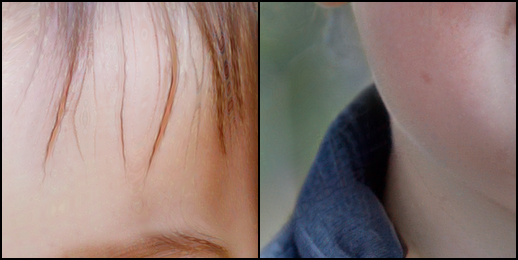

In [114]:
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
rez = patch_util.pil_crop_on_tensors(img_1k.permute(0, 3, 1, 2).clone(), c, r=True)
ToPILImage()(make_grid(rez, nrow=4))

In [50]:
with open('testa/ws.pkl', 'rb') as f:
    ws = pickle.load(f)


In [77]:
from util import patch_util

In [ ]:

www = torch.tensor([[ 3, 27,  8, 32],
        [11, 35,  2, 26]])

In [33]:
!source sh/setup40.sh
do_once(G_new, zs=q, outdir='test_z', coords = None, noise_mode='const')

Autoloading gmp/6.2.1/gcc-7.5.0-2px2tki
Autoloading mpc/1.1.0/gcc-7.5.0-osodvlz
Autoloading mpfr/4.1.0/gcc-7.5.0-ublhnmp
Autoloading zlib/1.2.11/gcc-7.5.0-h3xiplk
Autoloading zstd/1.5.0/gcc-7.5.0-qsdxtru
Autoloading cuda/10.2.89/gcc-7.5.0-jr6kobf
Autoloading libxml2/2.9.9/gcc-7.5.0-ouvtc2l
Autoloading libiconv/1.16/gcc-7.5.0-pndwbk6
Autoloading xz/5.2.4/gcc-7.5.0-55h4brm
Autoloading zlib/1.2.11/gcc-7.5.0-dsnnbcq
Autoloading libxml2/2.9.12/gcc-7.5.0-i2j2pf5
Autoloading libiconv/1.16/gcc-7.5.0-cvte7wx
Autoloading xz/5.2.5/gcc-7.5.0-sytpwnz
Autoloading zlib/1.2.11/gcc-7.5.0-h3xiplk
>Warning, using new style generator, but no coordinates specified
Generating image for z (0/2) ...
Generating image for z (1/2) ...


In [34]:
with open("testa/s.pkl", 'rb') as f:
    slice_position = pickle.load(f)

In [65]:
# change order 
slice_position

tensor([[ 9, 33,  1, 25],
        [ 2, 26,  7, 31]], device='cuda:0')

In [67]:

tt = torch.tensor([[ 3, 27,  8, 32],
        [11, 35,  2, 26]])



NameError: name 'z' is not defined

In [42]:
do_once(G_new, zs=q, outdir='test_z', coords = slice_position, noise_mode='const')

Using new style generator, and coordinates specified
Generating image for z (0/2) ...
Generating image for z (1/2) ...


In [62]:
ws = ws.cuda()

Check the model, if it is initialized correctly

In [152]:
import pickle

with open('testa/settings.pkl', 'rb') as f:
    settings = pickle.load(f)
from training.training_loop import training_loop

G, G_ema, loss = training_loop(**settings)

Loading training set...

Num images:  1260
Image shape: [3, 1024, 1024]
Label shape: [0]

Loading patch dataset...

Patch Num images:  1260
Patch Image shape: [3, 1024, 1024]
Patch Label shape: [0]

Constructing networks...
Using specified img resolution: 1024
cutoffs=array([  2.        ,   3.1748021 ,   5.0396842 ,   8.        ,
        12.69920842,  20.1587368 ,  32.        ,  50.79683366,
        80.63494719, 128.        , 203.18733465, 322.53978877,
       512.        , 512.        , 512.        ])
cutoffs=array([  2.        ,   3.1748021 ,   5.0396842 ,   8.        ,
        12.69920842,  20.1587368 ,  32.        ,  50.79683366,
        80.63494719, 128.        , 203.18733465, 322.53978877,
       512.        , 512.        , 512.        ])
Changing network to 4k version
cutoffs=array([2.00000000e+00, 3.56359487e+00, 6.34960421e+00, 1.13137085e+01,
       2.01587368e+01, 3.59187855e+01, 6.40000000e+01, 1.14035036e+02,
       2.03187335e+02, 3.62038672e+02, 6.45079578e+02, 1.1494011

In [154]:
with open('testa/t_e.pkl', 'rb') as f:
    t_e = pickle.load(f)

In [158]:
t_e.shape

torch.Size([2, 3, 3])

In [160]:
torch.eye(3,3).shape

torch.Size([3, 3])

Signature: loss.run_G(z, c, transform, slice_range=None, update_emas=False)
Docstring: <no docstring>
File:      /datawaha/cggroup/cvejica/anyres-gan/training/loss.py
Type:      method


In [161]:
import sys
hasattr(sys, 'gettrace') and sys.gettrace() is not None

True

In [ ]:
img, ws = loss.run_G(z_e, noise_mode='const', return_ws=True)

In [46]:
do_once(G, zs=q, outdir='test_z_a', coords = slice_position, noise_mode='const')

Using new style generator, and coordinates specified
Generating image for z (0/2) ...
Generating image for z (1/2) ...


In [47]:
slice_position

tensor([[ 9, 33,  1, 25],
        [ 2, 26,  7, 31]], device='cuda:0')

In [ ]:
coords

### Generation of do_once for 4k and 1k

In [2]:
import random

In [3]:
from util import patch_util
import torch
w = patch_util.generate_rng_positions(4) 

#wpix = patch_util.grid2pixel_tensor(w)

In [ ]:
x = random.randint(0, 12)

In [4]:
import dnnlib
import torch
import legacy
from training.networks_stylegan3 import Generator
network_pkl = "pretrained/stylegan3-r-ffhq-1024x1024.pkl"
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

In [3]:
with open('test/architexture1024.txt', 'w') as f:
    # write all up_filter and down_filter layers in named_parameters
    for name, layer in G.synthesis.named_buffers():
        if 'up_filter' in name or 'down_filter' in name:
            f.write(f"{name} - {layer.shape}:\n{layer}\n")

In [7]:
resolution = 1024 * 4
G_new = Generator(
    c_dim=0,
    img_resolution=resolution,
    img_channels=3,
    z_dim=512,
    w_dim=512,
    mapping_kwargs=dnnlib.EasyDict(num_layers=2),
    magnitude_ema_beta=0.5 ** (64 / (20 * 1e3)),
    conv_kernel = 1,
    channel_base = 32768 * 2,
    channel_max = 1024,
    use_radial_filters = True,
    actual_resolution = 1024,
).to(device)

#with open('outputs/1k_init.txt', 'w') as f:
#    f.write(str(G))

new_dict = {k: v for k, v in G.state_dict().items() if G_new.state_dict()[k].shape == v.shape}

old_dict = {k: v for k, v in G.state_dict().items() if G_new.state_dict()[k].shape != v.shape}
#G_new.synthesis.reconfigure_network(img_resolution=4096, channel_base=32768 * 2, channel_max=1024)
#G_new.load_state_dict(G.state_dict())
G_new.load_state_dict(new_dict, strict=False)

#print('Reinitilized G')

#G = G_new
##with open('outputs/4k_reconfig.txt', 'w') as f:
#    f.write(str(G))

cutoffs=array([2.00000000e+00, 3.56359487e+00, 6.34960421e+00, 1.13137085e+01,
       2.01587368e+01, 3.59187855e+01, 6.40000000e+01, 1.14035036e+02,
       2.03187335e+02, 3.62038672e+02, 6.45079578e+02, 1.14940114e+03,
       2.04800000e+03, 2.04800000e+03, 2.04800000e+03])
cutoffs=array([  2.        ,   3.1748021 ,   5.0396842 ,   8.        ,
        12.69920842,  20.1587368 ,  32.        ,  50.79683366,
        80.63494719, 128.        , 203.18733465, 322.53978877,
       512.        , 512.        , 512.        ])
Reminder: using all at 4096 except in_channels=1024 and out_channels=1024
Reminder: using all at 4096 except in_channels=1024 and out_channels=1024
Reminder: using all at 4096 except in_channels=1024 and out_channels=1024
Reminder: using all at 4096 except in_channels=1024 and out_channels=1024
Reminder: using all at 4096 except in_channels=1024 and out_channels=1024
Reminder: using all at 4096 except in_channels=1024 and out_channels=1024
Reminder: using all at 4096 exce

_IncompatibleKeys(missing_keys=['synthesis.L3_52_1024.up_filter', 'synthesis.L5_148_1024.up_filter', 'synthesis.L6_148_1024.up_filter', 'synthesis.L8_276_406.up_filter', 'synthesis.L9_532_256.up_filter', 'synthesis.L11_1044_102.up_filter'], unexpected_keys=[])

In [5]:

out_d1 = 'testa'
import os
if not os.path.exists(out_d1):
    os.makedirs(out_d1)
with open(f'{out_d1}/ar{resolution}.txt', 'w') as f:
    f.write(str(G_new))
with open(f'{out_d1}/buff{resolution}.txt', 'w') as f:
    for name, layer in G_new.synthesis.named_buffers():
        f.write(f"{name} - {layer.shape}:\n{layer}\n")

In [15]:
potential_list = [((k, k + 24), (k, k + 24)) for k in range(0, 16) if k + 24 <= 36]

In [8]:
def get_grid_params(resolution:int = 4096):
    """Get the grid parameters for a given resolution

    Args:
        resolution (int, optional): Resolution of the image. Defaults to 4096.

    Returns:
        list: List of tuples of the form (x, y)
    """
    if resolution == 4096:
        return _get_list_of_transforms(24, 4)
    elif resolution == 1024:
        return NotImplementedError("Theoreticall need to figure out") # _get_list_of_transforms(28, 3)
    else:
        raise ValueError("Resolution not supported")

def convert_to_abs_pixel_cordinates(grid_params):
    """Convert the grid parameters to absolute pixel cordinates

    Args:
        grid_params (list): List of tuples of the form ((x_start, x_end), (y_start, y_end))

    Returns:
        list: List of tuples of the form (x, y)
    """
    # map elements, such that each pair (0, 24), (4, 28), (8, 32), (12, 36) becomes (0, 1024), (1024, 2048), (2048, 3072), (3072, 4096)
    tuple_mapping = {
    (0, 24): (0, 1024),
    (4, 28): (1024, 2048),
    (8, 32): (2048, 3072),
    (12, 36): (3072, 4096)
    }
    return [(tuple_mapping[k], tuple_mapping[v]) for k, v in grid_params]
    

def _get_list_of_transforms(max_len=24, skip=4):
    """Generate list of transforms to produce a 4k image, from 1k segments
    Works for other resolutions, just need to change max_items, for 1k it is 28 and 

    Args:
        max_len (int, optional): _description_. Defaults to 24.
        skip (int, optional): How many features to skip for the next box. Defaults to 4.
    """
    # potential_list = [((k, k + max_len), (k, k + max_len)) for k in range(0, 36, skip)]
    potential_list = []
    for i in range(0, 36, skip):
        for k in range(0, 36, skip):
            if k + max_len <= 36 and i + max_len <= 36:
                potential_list.append(((k, k + max_len), (i, i + max_len)))
    
    return potential_list
    

In [21]:
x = torch.randn((16, 1024, 36, 36))

In [22]:
slice_range = get_grid_params(4096)


In [27]:
if slice_range is not None: # Added to slice images
    assert len(slice_range) == x.shape[0], "slice_range must be None or have the same length as the batch size"
    x = torch.stack([x[i, :, x_start:x_end, y_start:y_end] for i, ((x_start, x_end), (y_start, y_end)) in zip(range(x.shape[0]), slice_range)])
    
    

In [28]:
x.shape

torch.Size([16, 1024, 24, 24])

In [9]:
def grid2pixel(grid_params, res=1024, increment = 256):
    return [(tuple([k[0] * increment, k[0] * increment + res]), tuple([v[0] * increment, v[0] * increment + res])) for k, v in grid_params]


In [10]:
convert_to_abs_pixel_cordinates(get_grid_params(4096))

[((0, 1024), (0, 1024)),
 ((1024, 2048), (0, 1024)),
 ((2048, 3072), (0, 1024)),
 ((3072, 4096), (0, 1024)),
 ((0, 1024), (1024, 2048)),
 ((1024, 2048), (1024, 2048)),
 ((2048, 3072), (1024, 2048)),
 ((3072, 4096), (1024, 2048)),
 ((0, 1024), (2048, 3072)),
 ((1024, 2048), (2048, 3072)),
 ((2048, 3072), (2048, 3072)),
 ((3072, 4096), (2048, 3072)),
 ((0, 1024), (3072, 4096)),
 ((1024, 2048), (3072, 4096)),
 ((2048, 3072), (3072, 4096)),
 ((3072, 4096), (3072, 4096))]

In [17]:
#t = get_grid_params(4096)
grid2pixel(t)

[((256, 1280), (256, 1280)),
 ((1024, 2048), (0, 1024)),
 ((2048, 3072), (0, 1024)),
 ((3072, 4096), (0, 1024)),
 ((0, 1024), (1024, 2048)),
 ((1024, 2048), (1024, 2048)),
 ((2048, 3072), (1024, 2048)),
 ((3072, 4096), (1024, 2048)),
 ((0, 1024), (2048, 3072)),
 ((1024, 2048), (2048, 3072)),
 ((2048, 3072), (2048, 3072)),
 ((3072, 4096), (2048, 3072)),
 ((0, 1024), (3072, 4096)),
 ((1024, 2048), (3072, 4096)),
 ((2048, 3072), (3072, 4096)),
 ((3072, 4096), (3072, 4096))]

In [11]:
import os
import click
import PIL.Image
import numpy as np
import dnnlib
from training.networks_stylegan3 import Generator
from typing import List
def do_once(G_new: Generator, seeds:List[int],  truncation_psi=1, outdir:str='test',
            class_idx = None, extra="", translate=(0, 0), rotate=0, noise_mode = 'const',
            return_data=False, coords = None):
    assert seeds is not None
    assert G_new is not None
    
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    label = torch.zeros([1, G_new.c_dim], device=device)
    use_cords = False
    if hasattr(G_new, 'actual_resolution'):
        use_cords = True
        if coords is None:
            print('Warning, using new style generator, but no coordinates specified')
        else:
            print('Using new style generator, and coordinates specified')
    elif coords is not None:
        print('Warning, using old style generator, but coordinates specified')
    else:
        print('Using old style generator, and no coordinates specified')
    if G_new.c_dim != 0:
        if class_idx is None:
            raise click.ClickException('Must specify class label with --class when using a conditional network')
        label[:, class_idx] = 1
    else:
        if class_idx is not None:
            print ('warn: --class=lbl ignored when running on an unconditional network')
    from gen_images import make_transform
    
    # Generate images.
    for seed_idx, seed in enumerate(seeds):
        print('Generating image for seed %d (%d/%d) ...' % (seed, seed_idx, len(seeds)))
        num_at_once = len(coords) if coords is not None else 1
        #z = torch.from_numpy(np.random.RandomState(seed).randn(1, G_new.z_dim)).to(device)
        z = torch.from_numpy(np.random.RandomState(seed).randn(1, G_new.z_dim)).repeat((num_at_once,1)).to(device)
        # Construct an inverse rotation/translation matrix and pass to the generator.  The
        # generator expects this matrix as an inverse to avoid potentially failing numerical
        # operations in the network.
        if hasattr(G_new.synthesis, 'input'):
            m = make_transform(translate, rotate)
            m = np.linalg.inv(m)
            G_new.synthesis.input.transform.copy_(torch.from_numpy(m))
        extra_argument = {'slice_range': coords} if use_cords else {}
                
        torch.set_grad_enabled(False)
        ret_img = G_new(z, label, truncation_psi=truncation_psi, **extra_argument, noise_mode=noise_mode)
        
        
        img = (ret_img.clone().permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        
        PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/{extra}seed{seed:04d}.png')
        if return_data:
            return ret_img

In [14]:
# 1k 
!source sh/setup40.sh
seeds = list(range(16))
do_once(G, seeds, outdir='test1kf', extra="")

Autoloading gmp/6.2.1/gcc-7.5.0-2px2tki
Autoloading mpc/1.1.0/gcc-7.5.0-osodvlz
Autoloading mpfr/4.1.0/gcc-7.5.0-ublhnmp
Autoloading zlib/1.2.11/gcc-7.5.0-h3xiplk
Autoloading zstd/1.5.0/gcc-7.5.0-qsdxtru
Autoloading cuda/10.2.89/gcc-7.5.0-jr6kobf
Autoloading libxml2/2.9.9/gcc-7.5.0-ouvtc2l
Autoloading libiconv/1.16/gcc-7.5.0-pndwbk6
Autoloading xz/5.2.4/gcc-7.5.0-55h4brm
Autoloading zlib/1.2.11/gcc-7.5.0-dsnnbcq
Autoloading libxml2/2.9.12/gcc-7.5.0-i2j2pf5
Autoloading libiconv/1.16/gcc-7.5.0-cvte7wx
Autoloading xz/5.2.5/gcc-7.5.0-sytpwnz
Autoloading zlib/1.2.11/gcc-7.5.0-h3xiplk
>Using old style generator, and no coordinates specified
Generating image for seed 0 (0/16) ...
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
Generating image for seed 1 (1/16) ...
Generating image for seed 2 (2/16) ...
Generating image for seed 3 (3/16) ...
Generating image for seed 4 (4/16) ...
Generating image for seed 5 (5/16) ...
Generating image for seed 6 (6/16) ...
Generating image for see

In [19]:
import pickle

with open('testa/settings.pkl', 'rb') as f:
    settings = pickle.load(f)
from training.training_loop import training_loop
#settings['gpus'] = 1

In [22]:
training_loop(**settings)

Loading training set...

Num images:  1260
Image shape: [3, 1024, 1024]
Label shape: [0]

Loading patch dataset...

Patch Num images:  1260
Patch Image shape: [3, 1024, 1024]
Patch Label shape: [0]

Constructing networks...
Using specified img resolution: 1024
cutoffs=array([  2.        ,   3.1748021 ,   5.0396842 ,   8.        ,
        12.69920842,  20.1587368 ,  32.        ,  50.79683366,
        80.63494719, 128.        , 203.18733465, 322.53978877,
       512.        , 512.        , 512.        ])
cutoffs=array([  2.        ,   3.1748021 ,   5.0396842 ,   8.        ,
        12.69920842,  20.1587368 ,  32.        ,  50.79683366,
        80.63494719, 128.        , 203.18733465, 322.53978877,
       512.        , 512.        , 512.        ])
Changing network to 4k version
cutoffs=array([2.00000000e+00, 3.56359487e+00, 6.34960421e+00, 1.13137085e+01,
       2.01587368e+01, 3.59187855e+01, 6.40000000e+01, 1.14035036e+02,
       2.03187335e+02, 3.62038672e+02, 6.45079578e+02, 1.1494011

In [29]:
#!source setup40.sh
#G_new.synthesis.grid_parts = ((0, 36), (0, 36))
seeds = list(range(4))
do_once(G_new, seeds, outdir='test4096f', extra="4k_", coords=((0, 36), (0, 36)))

Using new style generator, and coordinates specified
Generating image for seed 0 (0/4) ...
Generating image for seed 1 (1/4) ...
Generating image for seed 2 (2/4) ...
Generating image for seed 3 (3/4) ...


In [30]:
#!source setup40.sh
#G_new.synthesis.grid_parts = ((0, 36), (0, 36))
seeds = list(range(4))
do_once(G_new, seeds, outdir='test4096f', extra="4k_")

Warning, using new style generator, but no coordinates specified
Generating image for seed 0 (0/4) ...
Generating image for seed 1 (1/4) ...
Generating image for seed 2 (2/4) ...
Generating image for seed 3 (3/4) ...


In [17]:
import timeit
slice_range = get_grid_params()
def first_imp(sl, sz=16):
    seeds = list(range(sz))
    device = torch.device('cuda')
    x = torch.randn((sz, 1024, 36, 36), device=device)
    if isinstance(sl, tuple):
        sl = [slice_range] * sz
    x = torch.stack([x[i, :, x_start:x_end, y_start:y_end] for i, ((x_start, x_end), (y_start, y_end)) in zip(range(x.shape[0]), sl)])
    return x

timeit.timeit(lambda: first_imp(slice_range), 'gc.enable()', number=10000)

1.9498007474467158

In [19]:
def construct_mask(sl, sz=16, x_shape=(1024, 24, 24)):
    device = torch.device('cuda')
    mask = torch.zeros((sz, *x_shape), dtype=torch.bool, device=device)
    for i, ((x_start, x_end), (y_start, y_end)) in enumerate(sl):
        mask[i, :, x_start:x_end, y_start:y_end] = True
    return mask

# mask = construct_mask(sl, sz=16)
def second_imp(sl, sz=16):
    seeds = list(range(sz))
    device = 'cuda'
    x = torch.randn((sz, 1024, 36, 36), device=device)
    if isinstance(sl, tuple):
        sl = [slice_range] * sz
    mask = construct_mask(sl, sz=sz, x_shape=x.shape[1:])
    x = x[mask]
    return x
timeit.timeit(lambda: second_imp(slice_range), 'gc.enable()', number=10000)

11.595504977740347

In [83]:
get_grid_params(resolution=4096)

[((0, 24), (0, 24)),
 ((4, 28), (0, 24)),
 ((8, 32), (0, 24)),
 ((12, 36), (0, 24)),
 ((0, 24), (4, 28)),
 ((4, 28), (4, 28)),
 ((8, 32), (4, 28)),
 ((12, 36), (4, 28)),
 ((0, 24), (8, 32)),
 ((4, 28), (8, 32)),
 ((8, 32), (8, 32)),
 ((12, 36), (8, 32)),
 ((0, 24), (12, 36)),
 ((4, 28), (12, 36)),
 ((8, 32), (12, 36)),
 ((12, 36), (12, 36))]

In [44]:
all_at_once = do_once(G_new, [0], coords=potential_list, outdir='test4096pw', extra="4k_", return_data=True)

Using new style generator, and coordinates specified
Generating image for seed 0 (0/1) ...


In [47]:
final_img= torch.zeros((1, 3, 4096, 4096), device='cuda')
for i, ((x_start, x_end), (y_start, y_end)) in enumerate(convert_to_abs_pixel_cordinates(potential_list)):
    final_img[:, :, x_start:x_end, y_start:y_end] = all_at_once[i]
#all_at_once.shape#
# convert to pil and save
img = (final_img.clone().permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'test4096pw/4k_final.png')

In [48]:
first_image = 'test4096pw/4k_final.png'
second_image = 'test4096p/4kt_seed0000.png'

# Read images with PIL
im1 = PIL.Image.open(first_image)
im2 = PIL.Image.open(second_image)
# with PIL. difference 
im3 = PIL.ImageChops.difference(im1, im2)
# calculate MSE
mse = np.mean((np.array(im1) - np.array(im2)) ** 2)
print('MSE: ', mse)


MSE:  0.07699326674143474


In [88]:
import random
x = random.randint(0, 12)
y = random.randint(0, 12)
coords = ((x, x+24), (y, y+24))
print(f"{coords}")
from util.patch_util import grid2pixel
print(f"{grid2pixel(coords)}")

((2, 26), (2, 26))
[((512, 1536), (512, 1536))]


In [115]:
import dnnlib
opts = dnnlib.EasyDict(
    data_hr = "/datawaha/cggroup/cvejica/SS750/HR",
    scale_min = 1,
    scale_max = 1,
    scale_anneal = -1,
    g_size = 1024,
    patch_crop = True,
    use_hr = True,
)
patch_kwargs = dnnlib.EasyDict(
            class_name='training.dataset.ImagePatchDataset',
            path=opts.data_hr, resolution=opts.g_size,
            scale_min=opts.scale_min, scale_max=opts.scale_max,
            scale_anneal=opts.scale_anneal, random_crop=opts.patch_crop,
            use_labels=True, max_size=None, xflip=False, use_hr=opts.use_hr)

In [116]:
training_set = dnnlib.util.construct_class_by_name(**patch_kwargs)
rank = 0
num_gpus = 1
device = torch.device('cuda')
from torch_utils import misc
random_seed = 0
batch_size = 16

In [117]:
num_gpus 

1

In [118]:
data_loader_kwargs = dict(pin_memory=True, num_workers=3, prefetch_factor=2)
patch_dset = dnnlib.util.construct_class_by_name(**patch_kwargs) # subclass of training.dataset.Dataset
patch_dset_sampler = misc.InfiniteSampler(dataset=patch_dset, rank=rank, num_replicas=num_gpus, seed=random_seed)
patch_dset_iterator = iter(torch.utils.data.DataLoader(dataset=patch_dset, sampler=patch_dset_sampler, batch_size=batch_size//num_gpus, **data_loader_kwargs))

In [119]:
d, p = next(patch_dset_iterator)
from torchvision.transforms import ToPILImage


In [130]:
coords = torch.stack(d['params']['coords']).permute(1,0)

In [131]:
s_rn = torch.stack(d['params']['split_range']).permute(1,0)

In [132]:
s_rn

tensor([[ 2, 26,  5, 29],
        [ 9, 33,  4, 28],
        [ 2, 26,  3, 27],
        [ 0, 24, 11, 35],
        [10, 34, 11, 35],
        [ 2, 26,  0, 24],
        [ 3, 27,  4, 28],
        [ 1, 25, 11, 35],
        [ 3, 27,  9, 33],
        [ 8, 32, 12, 36],
        [ 5, 29,  7, 31],
        [ 1, 25,  3, 27],
        [ 8, 32,  9, 33],
        [ 8, 32,  3, 27],
        [ 5, 29,  0, 24],
        [ 7, 31,  1, 25]])

In [133]:
coords

tensor([[ 512, 1280, 1536, 2304],
        [2304, 1024, 3328, 2048],
        [ 512,  768, 1536, 1792],
        [   0, 2816, 1024, 3840],
        [2560, 2816, 3584, 3840],
        [ 512,    0, 1536, 1024],
        [ 768, 1024, 1792, 2048],
        [ 256, 2816, 1280, 3840],
        [ 768, 2304, 1792, 3328],
        [2048, 3072, 3072, 4096],
        [1280, 1792, 2304, 2816],
        [ 256,  768, 1280, 1792],
        [2048, 2304, 3072, 3328],
        [2048,  768, 3072, 1792],
        [1280,    0, 2304, 1024],
        [1792,  256, 2816, 1280]])

In [ ]:
grid2pixel

In [134]:
from util import patch_util
patch_util.grid2pixel_tensor_f(s_rn.clone())

tensor([[ 512, 1536, 1280, 2304],
        [2304, 3328, 1024, 2048],
        [ 512, 1536,  768, 1792],
        [   0, 1024, 2816, 3840],
        [2560, 3584, 2816, 3840],
        [ 512, 1536,    0, 1024],
        [ 768, 1792, 1024, 2048],
        [ 256, 1280, 2816, 3840],
        [ 768, 1792, 2304, 3328],
        [2048, 3072, 3072, 4096],
        [1280, 2304, 1792, 2816],
        [ 256, 1280,  768, 1792],
        [2048, 3072, 2304, 3328],
        [2048, 3072,  768, 1792],
        [1280, 2304,    0, 1024],
        [1792, 2816,  256, 1280]])

In [135]:
# open testa/s_e.pkl and testa/z_e.pkl

with open('testa/s_e.pkl', 'rb') as f:
    s_e = pickle.load(f)
with open('testa/z_e.pkl', 'rb') as f:
    z_e = pickle.load(f)

    

In [150]:
outdir = 'testa'
extra = "test_"
seed = 1
## generate 4k image
label = torch.zeros([1, G_new.c_dim], device=device)
truncation_psi = 1
extra_argument = {"slice_range": s_e}
noise_mode = 'const'
ret_img = G_ema(z_e, label, truncation_psi=truncation_psi, **extra_argument, noise_mode=noise_mode)
        
        
img = (ret_img.clone().permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)

#PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/{extra}seed{seed:04d}.png')
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
#rez = patch_util.pil_crop_on_tensors(img_1k.permute(0, 3, 1, 2).clone(), c, r=True)


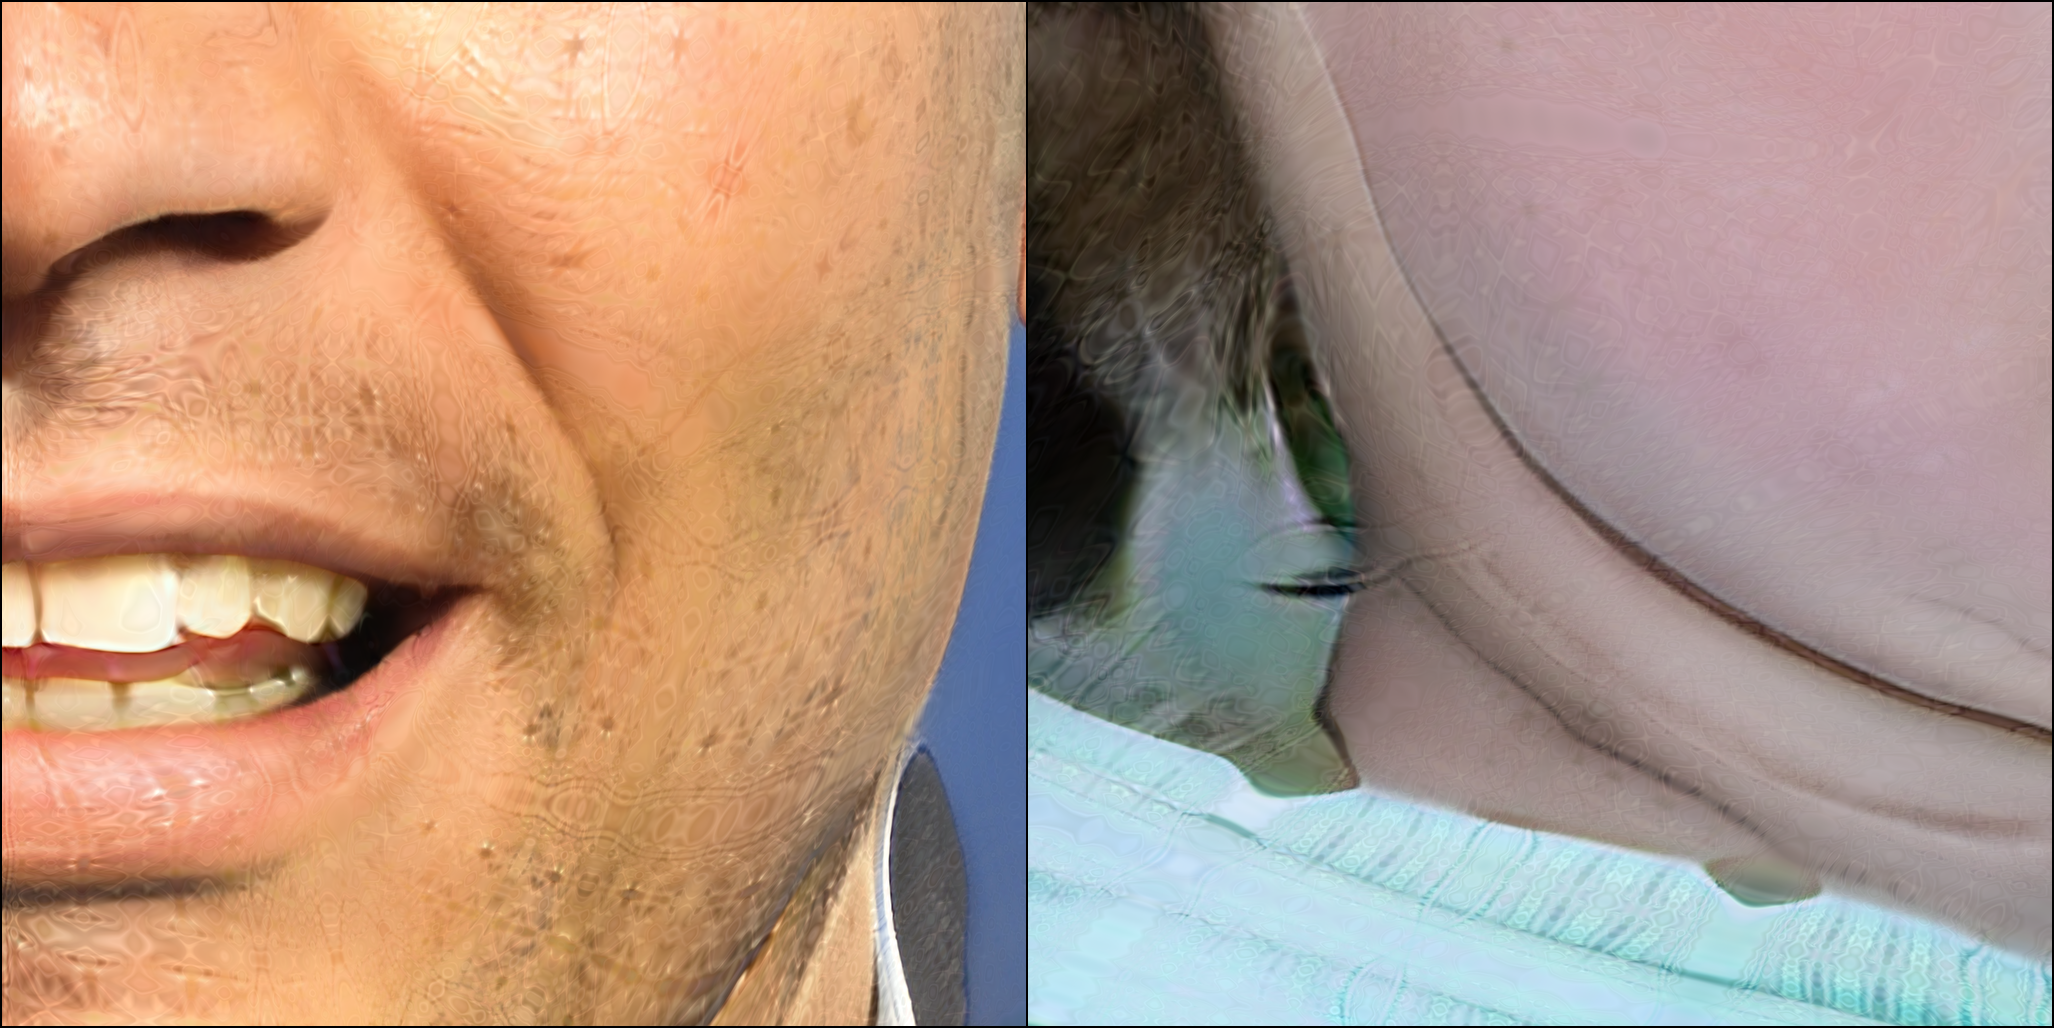

In [151]:
ToPILImage()(make_grid(img.permute(0, 3,1, 2), nrow=4))

In [139]:
img.shape

torch.Size([2, 1024, 1024, 3])

In [214]:
w = (0, 24, 0, 24)
from util import patch_util
r = patch_util.grid2pixel(w)
r


[(0, 1024, 0, 1024)]

In [196]:
w = torch.tensor([0, 24, 0, 24]).unsqueeze(0)
assert torch.any(w < 0, dim=1).item() == False and torch.any(w > 36, dim = 1).item() == False

In [235]:
patch_dset.sampler.patch_size

1024

In [243]:
len(w[0]['params']['coords'][0])

4

In [282]:

w[0]['params']['transform'].shape

torch.Size([16, 3, 3])

In [285]:

w[0]['params']['x']

tensor([3072,  256, 2304,  256,  256,    0, 1280, 3072, 2048,  512, 2560, 2816,
        1792, 1024,  768, 2816])

In [286]:
w[0]['params']['y']

tensor([ 768, 1792, 2560, 1280, 3072, 1536, 2560,  256, 2816, 1792, 2048, 3072,
         768,  768, 2816, 1024])

In [292]:
d, p = next(patch_dset_iterator)

In [115]:
re = patch_util.generate_random_positions_tensor(16, device=torch.device('cuda'))
re

tensor([[ 3, 27,  8, 32],
        [ 4, 28, 11, 35],
        [ 4, 28,  0, 24],
        [ 6, 30,  6, 30],
        [ 3, 27,  1, 25],
        [ 4, 28,  6, 30],
        [ 7, 31,  4, 28],
        [ 8, 32,  3, 27],
        [ 3, 27,  1, 25],
        [ 9, 33,  3, 27],
        [10, 34,  2, 26],
        [ 2, 26,  3, 27],
        [11, 35, 11, 35],
        [ 6, 30,  0, 24],
        [ 0, 24, 11, 35],
        [ 7, 31,  8, 32]], device='cuda:0')

In [111]:
re[0,2] = re[0, 0] * 256 + 1024
re[0,0] = re[0, 0] * 256
re[0,3] = re[0, 2] * 256 + 1024
re[0,1] = re[0, 2] * 256

In [116]:
patch_util.grid2pixel_tensor(re, 1024, 256)

tensor([[ 768, 2048, 1792, 3072],
        [1024, 2816, 2048, 3840],
        [1024,    0, 2048, 1024],
        [1536, 1536, 2560, 2560],
        [ 768,  256, 1792, 1280],
        [1024, 1536, 2048, 2560],
        [1792, 1024, 2816, 2048],
        [2048,  768, 3072, 1792],
        [ 768,  256, 1792, 1280],
        [2304,  768, 3328, 1792],
        [2560,  512, 3584, 1536],
        [ 512,  768, 1536, 1792],
        [2816, 2816, 3840, 3840],
        [1536,    0, 2560, 1024],
        [   0, 2816, 1024, 3840],
        [1792, 2048, 2816, 3072]], device='cuda:0')

### Just check to make sure that grid2pixel_tensor is working with different resolutions

In [124]:
# load test4096f/4k_seed0000.png with PIL, crop it with
import PIL
crop_params_4k = patch_util.grid2pixel_tensor(re, 1024, 256)[0]
crop_params_1k = patch_util.grid2pixel_tensor(re, 256, 64)[0]
print(f"{crop_params_4k=}")
print(f"{crop_params_1k=}")
img = PIL.Image.open('test4096f/4k_seed0000.png')
img_4k_c = img.crop(crop_params_4k.tolist())

# downsample the image to 1k
img_1k = img.resize((1024, 1024), PIL.Image.BILINEAR)

crop_params_4k=tensor([ 768, 2048, 1792, 3072], device='cuda:0')
crop_params_1k=tensor([192, 512, 448, 768], device='cuda:0')


/tmp/ipykernel_48282/2864061330.py:11: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img_1k = img.resize((1024, 1024), PIL.Image.BILINEAR)


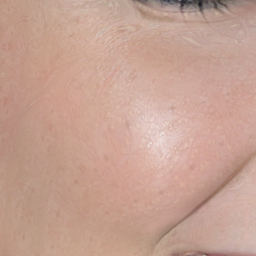

In [133]:
img_1k.crop(crop_params_1k.tolist())

In [140]:
from torchvision.transforms.functional import crop


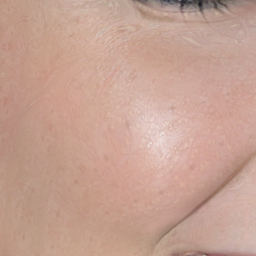

In [137]:
# do 1k img crop, on a tensor
from torchvision.transforms import ToTensor
img_1k_t = ToTensor()(img_1k)
img_1k_c = img_1k_t[:, crop_params_1k[1]:crop_params_1k[3], crop_params_1k[0]:crop_params_1k[2]]
# revert back to PIL to see if it is the same crop position
img_1k_c_pil = ToPILImage()(img_1k_c)
img_1k_c_pil

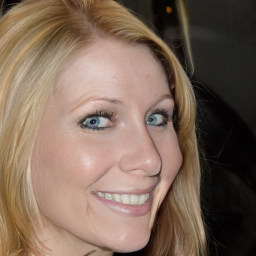

In [152]:
ToPILImage()(F.avg_pool2d(img_1k_t, 4))

In [154]:
w = torch.randn((5, 3, 256,256), device=torch.device('cuda'))

In [157]:
t = [1, 2, 3, 4, 5]
for v1,v2 in zip(t, w):
    print(v1)
    print(v2.shape)

1
torch.Size([3, 256, 256])
2
torch.Size([3, 256, 256])
3
torch.Size([3, 256, 256])
4
torch.Size([3, 256, 256])
5
torch.Size([3, 256, 256])


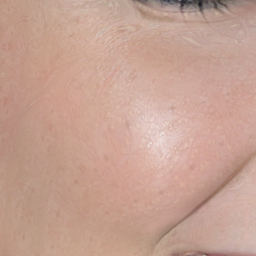

In [126]:
img_1k.crop(crop_params_1k.tolist())

NameError: name 'img_4k_t' is not defined

/tmp/ipykernel_48282/4126625997.py:1: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img_4k_c.resize((256, 256), PIL.Image.BILINEAR)


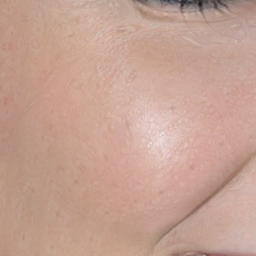

In [127]:
img_4k_c.resize((256, 256), PIL.Image.BILINEAR)

In [ ]:
img

In [74]:
patch_util.grid2pixel_tensor(re, 1024, 256)

tensor([[   0, 1024, 2816, 3840],
        [   0, 1024, 2816, 3840],
        [ 512, 1536,    0, 1024],
        [1024, 2048, 1536, 2560],
        [2816, 3840,  512, 1536],
        [   0, 1024, 2048, 3072],
        [1280, 2304, 2816, 3840],
        [1536, 2560, 1536, 2560],
        [ 768, 1792, 2560, 3584],
        [1024, 2048, 2560, 3584],
        [1792, 2816, 1536, 2560],
        [ 768, 1792, 1280, 2304],
        [ 768, 1792, 1792, 2816],
        [ 512, 1536, 2560, 3584],
        [1280, 2304, 2048, 3072],
        [2816, 3840,  768, 1792]], device='cuda:0')

In [70]:
patch_util.grid2pixel_tensor(re, 256, 64)

tensor([[  0, 256, 704, 960],
        [  0, 256, 704, 960],
        [128, 384,   0, 256],
        [256, 512, 384, 640],
        [704, 960, 128, 384],
        [  0, 256, 512, 768],
        [320, 576, 704, 960],
        [384, 640, 384, 640],
        [192, 448, 640, 896],
        [256, 512, 640, 896],
        [448, 704, 384, 640],
        [192, 448, 320, 576],
        [192, 448, 448, 704],
        [128, 384, 640, 896],
        [320, 576, 512, 768],
        [704, 960, 192, 448]], device='cuda:0')

In [34]:
re.split(8)

(tensor([[ 9, 33, 11, 35],
         [ 6, 30,  5, 29],
         [ 0, 24,  3, 27],
         [10, 34, 10, 34],
         [11, 35,  2, 26],
         [ 9, 33,  1, 25],
         [ 2, 26,  3, 27],
         [ 7, 31,  0, 24]], device='cuda:0'),
 tensor([[ 6, 30,  0, 24],
         [ 5, 29, 11, 35],
         [ 1, 25,  6, 30],
         [ 1, 25,  9, 33],
         [ 5, 29,  9, 33],
         [ 7, 31,  4, 28],
         [ 6, 30,  1, 25],
         [ 9, 33,  2, 26]], device='cuda:0'))

In [26]:
qqq = torch.tensor([[ 0, 24,  9, 33],
         [ 0, 24,  4, 28],
         [11, 35,  7, 31],
         [ 8, 32,  7, 31],
         [ 7, 31,  4, 28],
         [ 8, 32,  7, 31],
         [11, 35, 11, 35],
         [ 0, 24,  2, 26]], device='cuda:0')
qqq.shape

torch.Size([8, 4])

In [25]:
qqq[0]

tensor([ 0, 24,  9, 33], device='cuda:0')

In [305]:
torch.stack(d['params']['split_range']).permute(1,0).to(device).split(8)

(tensor([[ 0, 24,  9, 33],
         [ 0, 24,  4, 28],
         [11, 35,  7, 31],
         [ 8, 32,  7, 31],
         [ 7, 31,  4, 28],
         [ 8, 32,  7, 31],
         [11, 35, 11, 35],
         [ 0, 24,  2, 26]], device='cuda:0'),
 tensor([[ 4, 28,  3, 27],
         [ 5, 29,  0, 24],
         [ 0, 24,  0, 24],
         [11, 35,  3, 27],
         [ 1, 25,  2, 26],
         [12, 36,  6, 30],
         [ 8, 32,  9, 33],
         [ 3, 27, 11, 35]], device='cuda:0'))

In [299]:
torch.stack(d['params']['coords']).permute(1,0).to(device).split(4)

(tensor([[   0, 1024, 2304, 3328],
         [   0, 1024, 1024, 2048],
         [2816, 3840, 1792, 2816],
         [2048, 3072, 1792, 2816]], device='cuda:0'),
 tensor([[1792, 2816, 1024, 2048],
         [2048, 3072, 1792, 2816],
         [2816, 3840, 2816, 3840],
         [   0, 1024,  512, 1536]], device='cuda:0'),
 tensor([[1024, 2048,  768, 1792],
         [1280, 2304,    0, 1024],
         [   0, 1024,    0, 1024],
         [2816, 3840,  768, 1792]], device='cuda:0'),
 tensor([[ 256, 1280,  512, 1536],
         [3072, 4096, 1536, 2560],
         [2048, 3072, 2304, 3328],
         [ 768, 1792, 2816, 3840]], device='cuda:0'))

In [291]:
torch.stack(w[0]['params']['coords']).permute(1,0).split(4)

(tensor([[3072, 4096,  768, 1792],
         [ 256, 1280, 1792, 2816],
         [2304, 3328, 2560, 3584],
         [ 256, 1280, 1280, 2304]]),
 tensor([[ 256, 1280, 3072, 4096],
         [   0, 1024, 1536, 2560],
         [1280, 2304, 2560, 3584],
         [3072, 4096,  256, 1280]]),
 tensor([[2048, 3072, 2816, 3840],
         [ 512, 1536, 1792, 2816],
         [2560, 3584, 2048, 3072],
         [2816, 3840, 3072, 4096]]),
 tensor([[1792, 2816,  768, 1792],
         [1024, 2048,  768, 1792],
         [ 768, 1792, 2816, 3840],
         [2816, 3840, 1024, 2048]]))

In [236]:
w[0]['image'].shape

torch.Size([16, 3, 1024, 1024])

In [133]:
grid_params = torch.tensor([1])

assert grid_params is not None
assert isinstance(grid_params, torch.Tensor)

In [155]:
w.dim()

AttributeError: 'bool' object has no attribute 'dim'

In [156]:
w = torch.randn(1, 3, 4)

In [157]:
w.dim()

3

In [120]:
w[0]['params']['transform'].shape

torch.Size([16, 3, 3])

In [112]:
w[0]['image'].shape

torch.Size([16, 3, 4096, 4096])

In [ ]:
ToPILImage()(w[0]['image'].cpu())

In [31]:
seeds = list(range(16))
res = 4096

out_dir = f"test4096p"
for seed in seeds:
    potential_list = get_grid_params(resolution=res)
    final_img = torch.zeros((1, 3, res, res), device=device)
    for grid_sample, coords in zip(potential_list, convert_to_abs_pixel_cordinates(potential_list)):
        #G_new.synthesis.grid_parts = grid_sample
        img = do_once(G_new, [seed], coords=grid_sample, return_data=True, outdir=f"{out_dir}/{seed}", extra=f"{grid_sample[0][0]}_{grid_sample[0][1]}_{grid_sample[1][0]}_{grid_sample[1][1]}_")
        print(f"SHAPE={img.shape}")
        # img = img.permute(0, 3, 1, 2)
        print(f"FF:{img.shape=}")
        final_img[:, :, coords[0][0]:coords[0][1], coords[1][0]:coords[1][1]] = img.clone()
    
    final_img = (final_img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    print(f"{final_img.shape=}")
    PIL.Image.fromarray(final_img[0].cpu().numpy(), 'RGB').save(f'{out_dir}/4kt_seed{seed:04d}.png')
    #PIL.Image.fromarray(final_img[0].cpu().numpy(), 'RGB').save(f'{out_dir}/4kc_seed{seed:04d}.png')


Using new style generator, and coordinates specified
Generating image for seed 0 (0/1) ...
SHAPE=torch.Size([1, 3, 1024, 1024])
FF:img.shape=torch.Size([1, 3, 1024, 1024])
Using new style generator, and coordinates specified
Generating image for seed 0 (0/1) ...
SHAPE=torch.Size([1, 3, 1024, 1024])
FF:img.shape=torch.Size([1, 3, 1024, 1024])
Using new style generator, and coordinates specified
Generating image for seed 0 (0/1) ...
SHAPE=torch.Size([1, 3, 1024, 1024])
FF:img.shape=torch.Size([1, 3, 1024, 1024])
Using new style generator, and coordinates specified
Generating image for seed 0 (0/1) ...
SHAPE=torch.Size([1, 3, 1024, 1024])
FF:img.shape=torch.Size([1, 3, 1024, 1024])
Using new style generator, and coordinates specified
Generating image for seed 0 (0/1) ...
SHAPE=torch.Size([1, 3, 1024, 1024])
FF:img.shape=torch.Size([1, 3, 1024, 1024])
Using new style generator, and coordinates specified
Generating image for seed 0 (0/1) ...
SHAPE=torch.Size([1, 3, 1024, 1024])
FF:img.shape

KeyboardInterrupt: 

In [49]:
import torch
w = torch.randn(1, 1024, 36,36)

In [53]:
val = ((1, 25), (1, 25))
w[:, :, val[0][0]:val[0][1], val[1][0]:val[1][1]].shape

torch.Size([1, 1024, 24, 24])

In [3]:
def compare_models(model_teacher, model_new, verbose=False):
    total_diff = 0
    for name, param in model_new.named_parameters():
        value = model_teacher.state_dict().get(name, None)
        if value is not None:
            diff = torch.sum((param - value)**2)
            total_diff += diff
            if verbose:
                print(name, param.shape, value.shape, f"l2{diff.item()=}")
        else:
            if verbose:
                print(name, param.shape, "not found")
    final_str = f"total_diff={total_diff}"
    if verbose:
        print(final_str)
    return final_str

In [ ]:
compare_models(G_new, G4, verbose=True)

In [2]:
G_new

Generator(
  (synthesis): SynthesisNetwork(
    w_dim=512, num_ws=16,
    img_resolution=1024, img_channels=3,
    num_layers=14, num_critical=2,
    margin_size=10, num_fp16_res=4
    (input): SynthesisInput(
      w_dim=512, channels=1024, size=[36, 36],
      sampling_rate=16, bandwidth=2
      (affine): FullyConnectedLayer(in_features=512, out_features=4, activation=linear)
    )
    (L0_36_1024): SynthesisLayer(
      w_dim=512, is_torgb=False,
      is_critically_sampled=False, use_fp16=False,
      in_sampling_rate=16, out_sampling_rate=16,
      in_cutoff=2, out_cutoff=2,
      in_half_width=6, out_half_width=6,
      in_size=[36, 36], out_size=[36, 36],
      in_channels=1024, out_channels=1024
      (affine): FullyConnectedLayer(in_features=512, out_features=1024, activation=linear)
    )
    (L1_36_1024): SynthesisLayer(
      w_dim=512, is_torgb=False,
      is_critically_sampled=False, use_fp16=False,
      in_sampling_rate=16, out_sampling_rate=16,
      in_cutoff=2, out_

In [3]:
from training.networks_stylegan3 import Generator
import torch
import dnnlib
device = torch.device('cuda')

G_new = Generator(
    c_dim=0,
    img_resolution=1024,
    img_channels=3,
    z_dim=512,
    w_dim=512,
    mapping_kwargs=dnnlib.EasyDict(num_layers=2),
    magnitude_ema_beta=0.5 ** (64 / (20 * 1e3)),
    conv_kernel = 1,
    channel_base = 32768 * 2,
    channel_max = 1024,
    use_radial_filters = True,
).to(device)
new_dict = {k: v for k, v in G_new.state_dict().items() if G_new.state_dict()[k].shape == v.shape}
#print(new_dict.keys())
missing_keys, unexpected_keys  = G_new.load_state_dict(new_dict, strict=False)
del G_new


In [6]:
!source setup40.sh
batch_gpu = 1
z = torch.empty([batch_gpu, G_new.z_dim], device=device)
c = torch.empty([batch_gpu, G_new.c_dim], device=device)
inputs = dnnlib.EasyDict(z=z, c=c)
res = G_new(**inputs)

Autoloading gmp/6.2.1/gcc-7.5.0-2px2tki
Autoloading mpc/1.1.0/gcc-7.5.0-osodvlz
Autoloading mpfr/4.1.0/gcc-7.5.0-ublhnmp
Autoloading zlib/1.2.11/gcc-7.5.0-h3xiplk
Autoloading zstd/1.5.0/gcc-7.5.0-qsdxtru
Autoloading cuda/10.2.89/gcc-7.5.0-jr6kobf
Autoloading libxml2/2.9.9/gcc-7.5.0-ouvtc2l
Autoloading libiconv/1.16/gcc-7.5.0-pndwbk6
Autoloading xz/5.2.4/gcc-7.5.0-55h4brm
Autoloading zlib/1.2.11/gcc-7.5.0-dsnnbcq
Autoloading libxml2/2.9.12/gcc-7.5.0-i2j2pf5
Autoloading libiconv/1.16/gcc-7.5.0-cvte7wx
Autoloading xz/5.2.5/gcc-7.5.0-sytpwnz
Autoloading zlib/1.2.11/gcc-7.5.0-h3xiplk
>before torch.Size([1, 36, 36, 2])
up_factor before 2 torch.Size([1, 1024, 36, 36])
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
up_factor before 2 torch.Size([1, 1024, 36, 36])
up_factor before 4 torch.Size([1, 1024, 36, 36])
up_factor before 2 torch.Size([1, 1024, 52, 52])
up_factor before 4 torch.Size([1, 1024, 52, 52])
up_factor before 4 torch.Size([1, 1024, 84, 84])
up_factor before 2 torch.

In [7]:
# reconfigure_network(self, img_resolution, channel_base, channel_max):
G_new.synthesis.reconfigure_network(img_resolution=4096, channel_base=32768 * 2, channel_max=1024)

In [8]:
!source setup40.sh
batch_gpu = 1
z = torch.empty([batch_gpu, G_new.z_dim], device=device)
c = torch.empty([batch_gpu, G_new.c_dim], device=device)
inputs = dnnlib.EasyDict(z=z, c=c)
res = G_new(**inputs)
print(res.shape)

Autoloading gmp/6.2.1/gcc-7.5.0-2px2tki
Autoloading mpc/1.1.0/gcc-7.5.0-osodvlz
Autoloading mpfr/4.1.0/gcc-7.5.0-ublhnmp
Autoloading zlib/1.2.11/gcc-7.5.0-h3xiplk
Autoloading zstd/1.5.0/gcc-7.5.0-qsdxtru
Autoloading cuda/10.2.89/gcc-7.5.0-jr6kobf
Autoloading libxml2/2.9.9/gcc-7.5.0-ouvtc2l
Autoloading libiconv/1.16/gcc-7.5.0-pndwbk6
Autoloading xz/5.2.4/gcc-7.5.0-55h4brm
Autoloading zlib/1.2.11/gcc-7.5.0-dsnnbcq
Autoloading libxml2/2.9.12/gcc-7.5.0-i2j2pf5
Autoloading libiconv/1.16/gcc-7.5.0-cvte7wx
Autoloading xz/5.2.5/gcc-7.5.0-sytpwnz
Autoloading zlib/1.2.11/gcc-7.5.0-h3xiplk
>before torch.Size([1, 36, 36, 2])
up_factor before 2 torch.Size([1, 1024, 36, 36])
up_factor before 2 torch.Size([1, 1024, 36, 36])
up_factor before 4 torch.Size([1, 1024, 36, 36])
up_factor before 4 torch.Size([1, 1024, 52, 52])
up_factor before 4 torch.Size([1, 1024, 84, 84])
up_factor before 2 torch.Size([1, 1024, 148, 148])
up_factor before 4 torch.Size([1, 1024, 148, 148])
up_factor before 4 torch.Size([

: 

Autoloading gmp/6.2.1/gcc-7.5.0-2px2tki
Autoloading mpc/1.1.0/gcc-7.5.0-osodvlz
Autoloading mpfr/4.1.0/gcc-7.5.0-ublhnmp
Autoloading zlib/1.2.11/gcc-7.5.0-h3xiplk
Autoloading zstd/1.5.0/gcc-7.5.0-qsdxtru
Autoloading cuda/10.2.89/gcc-7.5.0-jr6kobf
Autoloading libxml2/2.9.9/gcc-7.5.0-ouvtc2l
Autoloading libiconv/1.16/gcc-7.5.0-pndwbk6
Autoloading xz/5.2.4/gcc-7.5.0-55h4brm
Autoloading zlib/1.2.11/gcc-7.5.0-dsnnbcq
Autoloading libxml2/2.9.12/gcc-7.5.0-i2j2pf5
Autoloading libiconv/1.16/gcc-7.5.0-cvte7wx
Autoloading xz/5.2.5/gcc-7.5.0-sytpwnz
Autoloading zlib/1.2.11/gcc-7.5.0-h3xiplk
>before torch.Size([1, 36, 36, 2])
up_factor before 2 torch.Size([1, 1024, 36, 36])
up_factor before 2 torch.Size([1, 1024, 36, 36])
up_factor before 4 torch.Size([1, 1024, 36, 36])
up_factor before 2 torch.Size([1, 1024, 52, 52])
up_factor before 4 torch.Size([1, 1024, 52, 52])
up_factor before 4 torch.Size([1, 1024, 84, 84])
up_factor before 2 torch.Size([1, 1024, 148, 148])
up_factor before 4 torch.Size([1,

In [14]:
from training.networks_stylegan3 import FullyConnectedLayer
w = FullyConnectedLayer(1,2)

In [15]:
w.device

AttributeError: 'FullyConnectedLayer' object has no attribute 'device'

In [9]:
# reconfigure_network(self, img_resolution, channel_base, channel_max):
G_new.synthesis.reconfigure_network(img_resolution=1024, channel_base=32768 * 2, channel_max=1024)

In [8]:
model = G_new.synthesis
# Loop over all the parameters or buffers in the model
for name, param in model.named_parameters():
    if param.is_cuda:
        print(f'{name} is on GPU device {param.get_device()}')
    else:
        print(f'{name} is on CPU device')

for name, buf in model.named_buffers():
    if buf.is_cuda:
        print(f'{name} buffer is on GPU device {buf.get_device()}')
    else:
        print(f'{name} buffer is on CPU device')

input.weight is on GPU device 0
input.affine.weight is on GPU device 0
input.affine.bias is on GPU device 0
L0_36_1024.weight is on GPU device 0
L0_36_1024.bias is on GPU device 0
L0_36_1024.affine.weight is on GPU device 0
L0_36_1024.affine.bias is on GPU device 0
L1_36_1024.weight is on GPU device 0
L1_36_1024.bias is on GPU device 0
L1_36_1024.affine.weight is on GPU device 0
L1_36_1024.affine.bias is on GPU device 0
L2_52_1024.weight is on GPU device 0
L2_52_1024.bias is on GPU device 0
L2_52_1024.affine.weight is on GPU device 0
L2_52_1024.affine.bias is on GPU device 0
L3_52_1024.weight is on GPU device 0
L3_52_1024.bias is on GPU device 0
L3_52_1024.affine.weight is on GPU device 0
L3_52_1024.affine.bias is on GPU device 0
L4_84_1024.weight is on GPU device 0
L4_84_1024.bias is on GPU device 0
L4_84_1024.affine.weight is on GPU device 0
L4_84_1024.affine.bias is on GPU device 0
L5_148_1024.weight is on GPU device 0
L5_148_1024.bias is on GPU device 0
L5_148_1024.affine.weight is

In [10]:
G_new.synthesis.L13_1024_64.up_filter

tensor([ 0.0234,  0.0344, -0.0509, -0.0786,  0.1396,  0.4321,  0.4321,  0.1396,
        -0.0786, -0.0509,  0.0344,  0.0234])

In [10]:
res = G_new(**inputs)
print(res.shape)

before torch.Size([1, 36, 36, 2])
up_factor before 2 torch.Size([1, 1024, 36, 36])


RuntimeError: all input tensors must reside on the same device

In [5]:
# G_new = Generator(
#     c_dim=0,
#     img_resolution=1024 * 4,
#     img_channels=3,
#     z_dim=512,
#     w_dim=512,
#     mapping_kwargs=dnnlib.EasyDict(num_layers=2),
#     magnitude_ema_beta=0.5 ** (64 / (20 * 1e3)),
#     conv_kernel = 1,
#     channel_base = 32768 * 2,
#     channel_max = 1024,
#     use_radial_filters = True,
# ).to(device)

In [ ]:
# for i in range(G_new.synthesis.num_layers +1):
#     print(f"layer {i}")

In [ ]:
# for idx, i in enumerate(G_new.synthesis.layer_names):
#     print(idx, i)

In [ ]:
# G_new.synthesis.layer_names

In [8]:
# self.design_lowpass_filter(
#             numtaps=self.up_taps, cutoff=self.in_cutoff, width=self.in_half_width*2, fs=self.tmp_sampling_rate)
G_new.synthesis.L0_36_1024.design_lowpass_filter(G_new.synthesis.L0_36_1024.up_taps, G_new.synthesis.L0_36_1024.in_cutoff, G_new.synthesis.L0_36_1024.in_half_width*2, G_new.synthesis.L0_36_1024.tmp_sampling_rate)

tensor([0.0008, 0.0100, 0.0389, 0.0924, 0.1565, 0.2013, 0.2013, 0.1565, 0.0924,
        0.0389, 0.0100, 0.0008])

In [13]:
(G_new.synthesis.L0_36_1024.up_taps, G_new.synthesis.L0_36_1024.in_cutoff, G_new.synthesis.L0_36_1024.in_half_width*2, G_new.synthesis.L0_36_1024.tmp_sampling_rate)

(12, 2.0, 12.0, 32)

In [14]:
G_new.synthesis.L0_36_1024.design_lowpass_filter(12, 2.0, 120, 1024)

tensor([0.0582, 0.0709, 0.0821, 0.0910, 0.0973, 0.1005, 0.1005, 0.0973, 0.0910,
        0.0821, 0.0709, 0.0582])

In [31]:
# check original channels, sizes, sampling rates, cutoffs, half_widths
for idx, cur_layer_name in enumerate(G_new.synthesis.layer_names):
    prev = max(0, idx - 1)
    layer = getattr(G_new.synthesis, G_new.synthesis.layer_names[prev])
    print(G_new.synthesis.L0_36_1024.design_lowpass_filter(layer.up_taps, layer.in_cutoff, layer.in_half_width*2, layer.tmp_sampling_rate).shape)

torch.Size([12])
torch.Size([12])
torch.Size([12])
torch.Size([24])
torch.Size([12])
torch.Size([24])
torch.Size([24])
torch.Size([12])
torch.Size([24])
torch.Size([12])
torch.Size([24])
torch.Size([24])
torch.Size([12])
torch.Size([12])
torch.Size([12])


In [9]:
t1024 = [{'up_taps': 12, 'in_cutoff': 2.0, 'in_half_width': 6.0, 'tmp_sampling_rate': 32, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': False},
{'up_taps': 12, 'in_cutoff': 2.0, 'in_half_width': 6.0, 'tmp_sampling_rate': 32, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': False},
{'up_taps': 24, 'in_cutoff': 3.1748021039363987, 'in_half_width': 4.825197896063601, 'tmp_sampling_rate': 64, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': False},
{'up_taps': 12, 'in_cutoff': 5.039684199579492, 'in_half_width': 10.960315800420508, 'tmp_sampling_rate': 64, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': False},
{'up_taps': 24, 'in_cutoff': 8.0, 'in_half_width': 8.0, 'tmp_sampling_rate': 128, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': False},
{'up_taps': 24, 'in_cutoff': 12.699208415745593, 'in_half_width': 19.300791584254405, 'tmp_sampling_rate': 256, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': False},
{'up_taps': 12, 'in_cutoff': 20.15873679831797, 'in_half_width': 43.841263201682025, 'tmp_sampling_rate': 256, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': False},
{'up_taps': 24, 'in_cutoff': 32.0, 'in_half_width': 32.0, 'tmp_sampling_rate': 512, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': False},
{'up_taps': 12, 'in_cutoff': 50.796833662982394, 'in_half_width': 77.2031663370176, 'tmp_sampling_rate': 512, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': False},
{'up_taps': 24, 'in_cutoff': 80.63494719327186, 'in_half_width': 47.365052806728144, 'tmp_sampling_rate': 1024, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': False},
{'up_taps': 24, 'in_cutoff': 128.0, 'in_half_width': 128.0, 'tmp_sampling_rate': 2048, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': False},
{'up_taps': 12, 'in_cutoff': 203.18733465192958, 'in_half_width': 308.8126653480704, 'tmp_sampling_rate': 2048, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': False},
{'up_taps': 12, 'in_cutoff': 322.5397887730874, 'in_half_width': 189.46021122691258, 'tmp_sampling_rate': 2048, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': True},
{'up_taps': 12, 'in_cutoff': 512.0, 'in_half_width': 118.34593963259715, 'tmp_sampling_rate': 2048, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': True},
{'up_taps': 1, 'in_cutoff': 512.0, 'in_half_width': 118.34593963259715, 'tmp_sampling_rate': 1024, 'is_torgb': True, 'filter_size': 6, 'is_critically_sampled': True}]
t4096 = [{'up_taps': 12, 'in_cutoff': 2.0, 'in_half_width': 6.0, 'tmp_sampling_rate': 32, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': False},
{'up_taps': 12, 'in_cutoff': 2.0, 'in_half_width': 6.0, 'tmp_sampling_rate': 32, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': False},
{'up_taps': 24, 'in_cutoff': 3.1748021039363987, 'in_half_width': 4.436405127438643, 'tmp_sampling_rate': 64, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': False},
{'up_taps': 24, 'in_cutoff': 5.039684199579492, 'in_half_width': 9.650395792127203, 'tmp_sampling_rate': 128, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': False},
{'up_taps': 24, 'in_cutoff': 8.0, 'in_half_width': 20.68629150101524, 'tmp_sampling_rate': 256, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': False},
{'up_taps': 12, 'in_cutoff': 12.699208415745593, 'in_half_width': 43.84126320168203, 'tmp_sampling_rate': 256, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': False},
{'up_taps': 24, 'in_cutoff': 20.15873679831797, 'in_half_width': 28.081214454100056, 'tmp_sampling_rate': 512, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': False},
{'up_taps': 24, 'in_cutoff': 32.0, 'in_half_width': 64.0, 'tmp_sampling_rate': 1024, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': False},
{'up_taps': 24, 'in_cutoff': 50.796833662982394, 'in_half_width': 141.96496407803653, 'tmp_sampling_rate': 2048, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': False},
{'up_taps': 12, 'in_cutoff': 80.63494719327186, 'in_half_width': 308.81266534807054, 'tmp_sampling_rate': 2048, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': False},
{'up_taps': 24, 'in_cutoff': 128.0, 'in_half_width': 149.96132803248764, 'tmp_sampling_rate': 4096, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': False},
{'up_taps': 24, 'in_cutoff': 203.18733465192958, 'in_half_width': 378.9204224538248, 'tmp_sampling_rate': 8192, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': False},
{'up_taps': 12, 'in_cutoff': 322.5397887730874, 'in_half_width': 898.5988625312023, 'tmp_sampling_rate': 8192, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': True},
{'up_taps': 12, 'in_cutoff': 512.0, 'in_half_width': 473.3837585303886, 'tmp_sampling_rate': 8192, 'is_torgb': False, 'filter_size': 6, 'is_critically_sampled': True},
{'up_taps': 1, 'in_cutoff': 512.0, 'in_half_width': 473.3837585303886, 'tmp_sampling_rate': 4096, 'is_torgb': True, 'filter_size': 6, 'is_critically_sampled': True}]

In [22]:
channels, sizes, sampling_rates, cutoffs, half_widths = G_new.synthesis.compute_stuff_for_resolution(1024, 32768*2, 1024)
for i in range(len(channels)):
    print(f"layer {i} channels {channels[i]} size {sizes[i]} sampling_rate {sampling_rates[i]} cutoff {cutoffs[i]} half_widths {half_widths[i]}")
    G_new.synthesis.L0_36_1024.design_lowpass_filter(channels[i], sizes[i], sampling_rates[i], cutoffs[i], half_widths[i])

layer 0 channels 1024.0 size 36.0 sampling_rate 16.0 cutoff 2.0 half_widths 6.0
layer 1 channels 1024.0 size 36.0 sampling_rate 16.0 cutoff 3.1748021039363987 half_widths 4.825197896063601


/home/cvejica/.conda/envs/anyres-gan/lib/python3.8/site-packages/numpy/lib/function_base.py:3360: RuntimeWarning: overflow encountered in exp
  return exp(x) * _chbevl(32.0/x - 2.0, _i0B) / sqrt(x)
/home/cvejica/.conda/envs/anyres-gan/lib/python3.8/site-packages/numpy/lib/function_base.py:3554: RuntimeWarning: invalid value encountered in divide
  return i0(beta * sqrt(1-((n-alpha)/alpha)**2.0))/i0(float(beta))


layer 2 channels 1024.0 size 52.0 sampling_rate 32.0 cutoff 5.039684199579492 half_widths 10.960315800420508
layer 3 channels 1024.0 size 52.0 sampling_rate 32.0 cutoff 8.0 half_widths 8.0
layer 4 channels 1024.0 size 84.0 sampling_rate 64.0 cutoff 12.699208415745593 half_widths 19.300791584254405
layer 5 channels 1024.0 size 148.0 sampling_rate 128.0 cutoff 20.15873679831797 half_widths 43.841263201682025
layer 6 channels 1024.0 size 148.0 sampling_rate 128.0 cutoff 32.0 half_widths 32.0
layer 7 channels 645.0 size 276.0 sampling_rate 256.0 cutoff 50.796833662982394 half_widths 77.2031663370176
layer 8 channels 406.0 size 276.0 sampling_rate 256.0 cutoff 80.63494719327186 half_widths 47.365052806728144
layer 9 channels 256.0 size 532.0 sampling_rate 512.0 cutoff 128.0 half_widths 128.0
layer 10 channels 161.0 size 1044.0 sampling_rate 1024.0 cutoff 203.18733465192958 half_widths 308.8126653480704
layer 11 channels 102.0 size 1044.0 sampling_rate 1024.0 cutoff 322.5397887730874 half_wi

/datawaha/cggroup/cvejica/stylegan3/training/networks_stylegan3.py:450: RuntimeWarning: invalid value encountered in divide
  f = scipy.special.j1(2 * cutoff * (np.pi * r)) / (np.pi * r)


In [20]:
channels, sizes, sampling_rates, cutoffs, half_widths = G_new.synthesis.compute_stuff_for_resolution(4096, 32768*2, 1024)
print(f"First one: {channels[0]}, {sizes[0]}, {sampling_rates[0]}, {cutoffs[0]}, {half_widths[0]}")

First one: 1024.0, 36.0, 16.0, 2.0, 6.0


In [7]:
# reconfigure_network(self, img_resolution, channel_base, channel_max):
G_new.synthesis.reconfigure_network(img_resolution=1024, channel_base=32768 * 2, channel_max=1024)

self.up_taps=12, self.in_cutoff=2.0, self.in_half_width=6.0, self.tmp_sampling_rate=32
self.up_taps=12, self.in_cutoff=2.0, self.in_half_width=6.0, self.tmp_sampling_rate=32
self.up_taps=24, self.in_cutoff=3.1748021039363987, self.in_half_width=4.825197896063601, self.tmp_sampling_rate=64
self.up_taps=12, self.in_cutoff=5.039684199579492, self.in_half_width=10.960315800420508, self.tmp_sampling_rate=64
self.up_taps=24, self.in_cutoff=8.0, self.in_half_width=8.0, self.tmp_sampling_rate=128
self.up_taps=24, self.in_cutoff=12.699208415745593, self.in_half_width=19.300791584254405, self.tmp_sampling_rate=256
self.up_taps=12, self.in_cutoff=20.15873679831797, self.in_half_width=43.841263201682025, self.tmp_sampling_rate=256
self.up_taps=24, self.in_cutoff=32.0, self.in_half_width=32.0, self.tmp_sampling_rate=512
self.up_taps=12, self.in_cutoff=50.796833662982394, self.in_half_width=77.2031663370176, self.tmp_sampling_rate=512
self.up_taps=24, self.in_cutoff=80.63494719327186, self.in_half_w

AssertionError: up_filter is None, self.tmp_sampling_rate=1024, self.in_sampling_rate=1024, self.up_factor=1, self.up_taps=1, self.in_half_width=118.34593963259715, self.in_cutoff=512.0

In [8]:
# again sample image
res = G_new(**inputs)

before torch.Size([1, 36, 36, 2])
up_factor before 2 torch.Size([2, 1024, 36, 36])


RuntimeError: all input tensors must reside on the same device

In [11]:
missing_keys

[]

In [13]:
G_new.__dict__

{'training': False,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_hooks': OrderedDict(),
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': OrderedDict([('synthesis',
               SynthesisNetwork(
                 w_dim=512, num_ws=16,
                 img_resolution=1024, img_channels=3,
                 num_layers=14, num_critical=2,
                 margin_size=10, num_fp16_res=4
                 (input): SynthesisInput(
                   w_dim=512, channels=1024, size=[36, 36],
                   sampling_rate=16, bandwidth=2
                   (affine): FullyConnectedLayer(in_features=512, out_features=4, activation=linear)
                 )
                 (L0_36_1024): SynthesisLayer(
                   w_dim=512, is_torgb=False,
                   is_critically_sampled=False, use_fp16=False,
  

: 

In [15]:
# check to return back
for k in missing_keys:
    G_new.state_dict()[k] = G_new.state_dict()[k]
print(G_new)

Generator(
  (synthesis): SynthesisNetwork(
    w_dim=512, num_ws=16,
    img_resolution=4096, img_channels=3,
    num_layers=14, num_critical=2,
    margin_size=10, num_fp16_res=4
    (input): SynthesisInput(
      w_dim=512, channels=1024, size=[36, 36],
      sampling_rate=16, bandwidth=2
      (affine): FullyConnectedLayer(in_features=512, out_features=4, activation=linear)
    )
    (L0_36_1024): SynthesisLayer(
      w_dim=512, is_torgb=False,
      is_critically_sampled=False, use_fp16=False,
      in_sampling_rate=16, out_sampling_rate=16,
      in_cutoff=2, out_cutoff=2,
      in_half_width=6, out_half_width=6,
      in_size=[36, 36], out_size=[36, 36],
      in_channels=1024, out_channels=1024
      (affine): FullyConnectedLayer(in_features=512, out_features=1024, activation=linear)
    )
    (L1_36_1024): SynthesisLayer(
      w_dim=512, is_torgb=False,
      is_critically_sampled=False, use_fp16=False,
      in_sampling_rate=16, out_sampling_rate=16,
      in_cutoff=2, out_

In [39]:
dict(ran = 2)

{'ran': 2}